## Research Project
Dylan Rohan - a1844790

In [235]:
# Importing required modules - Data analysis
from ucimlrepo import fetch_ucirepo                                           # Accessing UCI Repository
import pandas as pd                                                           # For Dataframe creation and manipulation 
import numpy as np                                                            # For array manipulation and calculations 
from pathlib import Path                                                      # To assist in saving output
import matplotlib.pyplot as plt                                               # For plotting purposes
import seaborn as sns                                                         # To leverage its style settings and simple colouring parameters 

# Importing required modules - Modelling tools
from sklearn import model_selection                                           # sklearn packages used to preprocess, build, and validate the model
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import umap.umap_ as umap                                                     # To build the UMAP model for data embedding into a 2d space
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
import hdbscan as HDBSCAN_2                                                   # An HDBSCAN model with more functionality
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error 
#from scipy.spatial.distance import cdist                                      
import time                                                                   # Used to measure processing duration and ...
import datetime                                                               # ... to save output by date and time
from scipy.stats import chi2_contingency, norm, chisquare                     # Used in the statistical analysis
from scipy.cluster.hierarchy import dendrogram                                # Used to create the secondary HDBSCAN's dendrogram

# Global settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette('viridis')

### Data acquisition

In [236]:
# Obtaining data
diabetes_data = fetch_ucirepo(id = 296) 
X = diabetes_data.data.features 
y = diabetes_data.data.targets 

# Compiling into single dataset
X['readmitted'] = y

# Renaming dataframe variable
medical_df = X.copy()

# Printing Metadata 
print(diabetes_data.metadata) 

C:\Users\Dylan Rohan\anaconda3\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

C:\Users\Dylan Rohan\AppData\Local\Temp\ipykernel_7668\532052657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['readmitted'] = y


In [237]:
# Function to find unique variables
def unique_feature_values(feature):
    if feature in medical_df.columns:
        return medical_df[feature].unique()


# Obtaining the original data dictionary information and collating unique feature values
data_dictionary = diabetes_data.variables[['name', 'type', 'description']].copy()
data_dictionary['feature values']= data_dictionary['name'].map(unique_feature_values)
#data_dictionary.to_csv('Data_dictionary.csv')
data_dictionary

name         type  \
0               encounter_id                
1                patient_nbr                
2                       race  Categorical   
3                     gender  Categorical   
4                        age  Categorical   
5                     weight  Categorical   
6          admission_type_id  Categorical   
7   discharge_disposition_id  Categorical   
8        admission_source_id  Categorical   
9           time_in_hospital      Integer   
10                payer_code  Categorical   
11         medical_specialty  Categorical   
12        num_lab_procedures      Integer   
13            num_procedures      Integer   
14           num_medications      Integer   
15         number_outpatient      Integer   
16          number_emergency      Integer   
17          number_inpatient      Integer   
18                    diag_1  Categorical   
19                    diag_2  Categorical   
20                    diag_3  Categorical   
21          number_diagnoses      Integer   
22             max_glu_serum  Categorical   
23                 A1Cresult  Categorical   
24                 metformin  Categorical   
25               repaglinide  Categorical   
26               nateglinide  Categorical   
27            chlorpropamide  Categorical   
28               glimepiride  Categorical   
29             acetohexamide  Categorical   
30                 glipizide  Categorical   
31                 glyburide  Categorical   
32               tolbutamide  Categorical   
33              pioglitazone  Categorical   
34             rosiglitazone  Categorical   
35                  acarbose  Categorical   
36                  miglitol  Categorical   
37              troglitazone  Categorical   
38                tolazamide  Categorical   
39                   examide  Categorical   
40               citoglipton  Categorical   
41                   insulin  Categorical   
42       glyburide-metformin  Categorical   
43       glipizide-metformin  Categorical   
44  glimepiride-pioglitazone  Categorical   
45   metformin-rosiglitazone  Categorical   
46    metformin-pioglitazone  Categorical   
47                    change  Categorical   
48               diabetesMed  Categorical   
49                readmitted  Categorical   

                                          description  \
0                   Unique identifier of an encounter   
1                      Unique identifier of a patient   
2   Values: Caucasian, Asian, African American, Hi...   
3           Values: male, female, and unknown/invalid   
4   Grouped in 10-year intervals: [0, 10), [10, 20...   
5                                   Weight in pounds.   
6   Integer identifier corresponding to 9 distinct...   
7   Integer identifier corresponding to 29 distinc...   
8   Integer identifier corresponding to 21 distinc...   
9   Integer number of days between admission and d...   
10  Integer identifier corresponding to 23 distinc...   
11  Integer identifier of a specialty of the admit...   
12  Number of lab tests performed during the encou...   
13  Number of procedures (other than lab tests) pe...   
14  Number of distinct generic names administered ...   
15  Number of outpatient visits of the patient in ...   
16  Number of emergency visits of the patient in t...   
17  Number of inpatient visits of the patient in t...   
18  The primary diagnosis (coded as first three di...   
19  Secondary diagnosis (coded as first three digi...   
20  Additional secondary diagnosis (coded as first...   
21          Number of diagnoses entered to the system   
22  Indicates the range of the result or if the te...   
23  Indicates the range of the result or if the te...   
24  The feature indicates whether the drug was pre...   
25  The feature indicates whether the drug was pre...   
26  The feature indicates whether the drug was pre...   
27  The feature indicates whether the drug was pre...   
28  The feature indicates whether the drug was pre...   
29  The feature in

In [238]:
print(f'The dataset imported with the shape: {medical_df.shape}')

The dataset imported with the shape: (101766, 48)


### Data Preparation and Cleaning

In [239]:
# Reformatting missing values
medical_df.replace("NaN", np.nan)

# Tabulating missing value counts
## Counting
missing_values = medical_df.isna().sum()

## Making a Dataframe with new numbered index
missing_values_df = pd.DataFrame(missing_values).reset_index()

## Renaming Columns
missing_values_df.columns = ['Feature', 'Count']

# Presenting only Features with missing values
print("Missing values summary:") 
missing_values_df[missing_values_df['Count'] > 0].reset_index(drop = True)

Missing values summary:


Feature  Count
0               race   2273
1             weight  98569
2         payer_code  40256
3  medical_specialty  49949
4             diag_1     21
5             diag_2    358
6             diag_3   1423

The patient ID feature needed to determine readmission and remove duplicate patients is missing. The project will instead have to consider 'encounters' and not 'individuals'. Weight is also poorly recorded, dissapointing as it is a known perceivable feature that can influence patient treatment or result in prejudice. In any case, it will be ommitted. 

A few variations of the data will be compiled, one with high instances, one with high dimensionality, and one using principle components.

In [240]:
# Making a selection of features binary to reduce variance
## change
def binary_change(value):
    if value == 'No':
        return 0
    elif value =='Ch':
        return 1

## DiabetesMed
def binary_diabetesmed(value):
    if value == 'No':
        return 0
    elif value =='Yes':
        return 1

## Readmitted
def binary_readmitted(value):
    if value == 'NO':
        return 0
    elif value == '>30':
        return 1
    elif value == '<30':
        return 1

# Applying above functions to update the values as binary
medical_df['diabetesMed'] = medical_df['diabetesMed'].map(binary_diabetesmed)
medical_df['change'] = medical_df['change'].map(binary_change)
medical_df['readmitted'] = medical_df['readmitted'].map(binary_readmitted)
medical_df

race  gender      age weight  admission_type_id  \
0             Caucasian  Female   [0-10)    NaN                  6   
1             Caucasian  Female  [10-20)    NaN                  1   
2       AfricanAmerican  Female  [20-30)    NaN                  1   
3             Caucasian    Male  [30-40)    NaN                  1   
4             Caucasian    Male  [40-50)    NaN                  1   
...                 ...     ...      ...    ...                ...   
101761  AfricanAmerican    Male  [70-80)    NaN                  1   
101762  AfricanAmerican  Female  [80-90)    NaN                  1   
101763        Caucasian    Male  [70-80)    NaN                  1   
101764        Caucasian  Female  [80-90)    NaN                  2   
101765        Caucasian    Male  [70-80)    NaN                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
0                             25                    1                 1   
1                              1                    7                 3   
2                              1                    7                 2   
3                              1                    7                 2   
4                              1                    7                 1   
...                          ...                  ...               ...   
101761                         3                    7                 3   
101762                         4                    5                 5   
101763                         1                    7                 1   
101764                         3                    7                10   
101765                         1                    7                 6   

       payer_code         medical_specialty  num_lab_procedures  \
0             NaN  Pediatrics-Endocrinology                  41   
1             NaN                       NaN                  59   
2             NaN                       NaN                  11   
3             NaN                       NaN                  44   
4             NaN                       NaN                  51   
...           ...                       ...                 ...   
101761         MC                       NaN                  51   
101762         MC                       NaN                  33   
101763         MC                       NaN                  53   
101764         MC           Surgery-General                  45   
101765        NaN                       NaN                  13   

        num_procedures  num_medications  number_outpatient  number_emergency  \
0                    0                1                  0                 0   
1                    0               18                  0                 0   
2                    5               13                  2                 0   
3                    1               16                  0                 0   
4                    0                8                  0                 0   
...                ...              ...                ...               ...   
101761               0               16                  0                 0   
101762               3               18                  0                 0   
101763               0                9                  1                 0   
101764               2               21                  0                 0   
101765               3                3                  0                 0   

        number_inpatient  diag_1  diag_2 diag_3  number_diagnoses  \
0                      0  250.83     NaN    NaN                 1   
1                      0     276  250.01    255                 9   
2                      1     648     250    V27                 6   
3                      0       8  250.43    403                 7   
4                      0     197     157    250                 5   
...                  ...     ...     ...    ...               ...   
101761                 0  25

In [241]:
## Low instance dataset 
# Including 'medical_specialty' and 'payer_code'  
low_instances_df = medical_df[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                       'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
                       'number_emergency', 'number_inpatient', 'number_diagnoses',  'change', 'diabetesMed', 'readmitted',
                       'medical_specialty', 'payer_code']].copy()

# Measuring shape change and removing nan values
print(f"To include 'payer code' and 'medical speciality', there is a reduction of {low_instances_df.isnull().any(axis = 1).sum()} rows")
low_instances_df = low_instances_df.dropna().reset_index(drop = True)

## High instance dataset
# Excluding 'medical_specialty' and 'payer_code'
high_instances_df = medical_df[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                       'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
                       'number_emergency', 'number_inpatient', 'number_diagnoses',  'change', 'diabetesMed', 'readmitted']].copy()

# Measuring shape change and removing nan values
print(f"Excluding these features results in only a reduction of {high_instances_df.isnull().any(axis = 1).sum()} rows")
high_instances_df = high_instances_df.dropna().reset_index(drop = True)
print(f"The former has {len(low_instances_df)} instances, and the latter has {len(high_instances_df)} instances")

## Removed due to overwhelming number of missing values or translation issues:
# 'weight','diag_1', 'diag_2', 'diag_3',  'admission_source_id'

## The below are about prescription alterations -> socioeconomicly important but not practically informative in this instance:
# 'max_glu_serum', 'A1Cresult', 'metformin',
# 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
# 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#  'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#  'tolazamide', 'examide', 'citoglipton', 'insulin',
#  'glyburide-metformin', 'glipizide-metformin',
#  'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#  'metformin-pioglitazone',

To include 'payer code' and 'medical speciality', there is a reduction of 74626 rows
Excluding these features results in only a reduction of 2273 rows
The former has 27140 instances, and the latter has 99493 instances


In [242]:
# low_instances_df - Explicity assigning data types
ordered_dtype_li = [str, str, str, int, int, int, int, int, int, int, int, int, int, str, str, str, str, str]
position = 0
for feature in low_instances_df:
    low_instances_df[feature] = low_instances_df[feature].astype(ordered_dtype_li[position])
    position += 1

# Checking dtyes
print(low_instances_df.dtypes)

race                        object
gender                      object
age                         object
admission_type_id            int32
discharge_disposition_id     int32
time_in_hospital             int32
num_lab_procedures           int32
num_procedures               int32
num_medications              int32
number_outpatient            int32
number_emergency             int32
number_inpatient             int32
number_diagnoses             int32
change                      object
diabetesMed                 object
readmitted                  object
medical_specialty           object
payer_code                  object
dtype: object


In [243]:
## high_instances_df - Explicity assigning data types
ordered_dtype_hi = [str, str, str, int, int, int, int, int, int, int, int, int, int, str, str, str]
position = 0
for feature in high_instances_df:
    high_instances_df[feature] = high_instances_df[feature].astype(ordered_dtype_hi[position])
    position += 1

# Checking dtyes
print(high_instances_df.dtypes)

race                        object
gender                      object
age                         object
admission_type_id            int32
discharge_disposition_id     int32
time_in_hospital             int32
num_lab_procedures           int32
num_procedures               int32
num_medications              int32
number_outpatient            int32
number_emergency             int32
number_inpatient             int32
number_diagnoses             int32
change                      object
diabetesMed                 object
readmitted                  object
dtype: object


In [244]:
# Viewing Dataframe
print('Viewing Dataframe')
high_instances_df.head()

Viewing Dataframe


race  gender      age  admission_type_id  \
0        Caucasian  Female   [0-10)                  6   
1        Caucasian  Female  [10-20)                  1   
2  AfricanAmerican  Female  [20-30)                  1   
3        Caucasian    Male  [30-40)                  1   
4        Caucasian    Male  [40-50)                  1   

   discharge_disposition_id  time_in_hospital  num_lab_procedures  \
0                        25                 1                  41   
1                         1                 3                  59   
2                         1                 2                  11   
3                         1                 2                  44   
4                         1                 1                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  number_diagnoses change diabetesMed readmitted  
0                 0                 1      0           0          0  
1                 0                 9      1           1          1  
2                 1                 6      0           1          0  
3                 0                 7      1           1          0  
4                 0                 5      1           1          0

In [245]:
# Viewing Dataframe
print('Viewing Dataframe')
low_instances_df.head()

Viewing Dataframe


race  gender       age  admission_type_id  discharge_disposition_id  \
0  Caucasian  Female   [70-80)                  1                        22   
1  Caucasian  Female   [60-70)                  2                         1   
2  Caucasian  Female  [90-100)                  1                         1   
3  Caucasian    Male   [70-80)                  1                         2   
4  Caucasian  Female   [70-80)                  1                         3   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 7                  58               2               15   
1                 3                  59               3               11   
2                 4                  56               1                9   
3                10                  68               1               18   
4                12                  77               5               19   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 9   
1                  0                 0                 0                 6   
2                  0                 0                 0                 6   
3                  0                 0                 0                 6   
4                  0                 0                 0                 5   

  change diabetesMed readmitted           medical_specialty payer_code  
0      1           1          0  Orthopedics-Reconstructive         MC  
1      0           1          0                  Nephrology         MC  
2      0           1          0            Emergency/Trauma         MC  
3      1           1          0            InternalMedicine         MC  
4      0           1          0            InternalMedicine         UN

### Exploratory Data Analysis

The below chart represents the population of individuals included in the  high instance dataset after removing payer_code and medical_speciality:


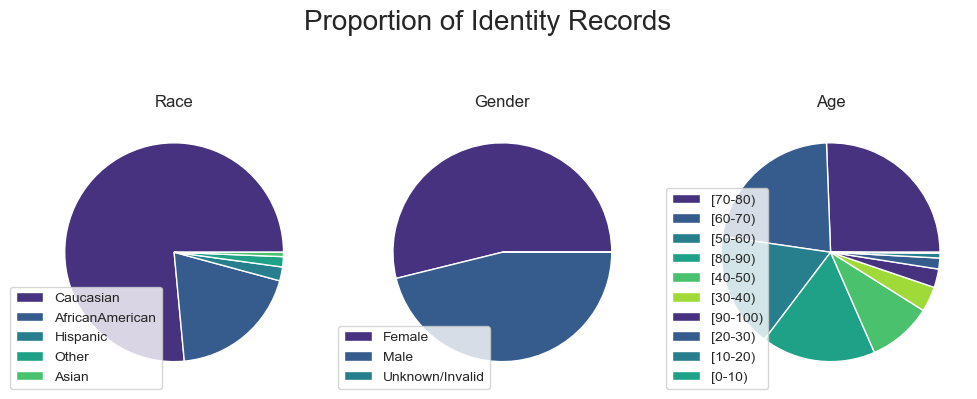

In [246]:
## Group Representation
# Counting occurrences of each identity category
race_count = high_instances_df['race'].value_counts()
gender_count = high_instances_df['gender'].value_counts()
age_count = high_instances_df['age'].value_counts()

# Compiling counts and preparing titles for vizualizations
counts = [race_count, gender_count, age_count] 
title = ["Race" , "Gender", "Age"]

# Vizualizing the representation (pie charts)
print("The below chart represents the population of individuals included in the "\
      " high instance dataset after removing payer_code and medical_speciality:")
plt.subplots(1, 3, figsize = (12, 5))
plt.suptitle("Proportion of Identity Records", size = 20)
plt.axis('off')
position = 1
for element in counts:
    plt.subplot(1, 3, position)
    plt.pie(element, )
    plt.title(title[position-1])
    plt.legend(labels = element.keys(), loc = [-0.1, 0])
    #plt.annotate(f'total = {sum(element)}', xy = (-1,-1))
    position += 1

In [247]:
# Count matrix to find subsets of encounters
print("Representation counts accross three key identity features:")
high_instances_df.groupby(['race','gender', 'age']).size().unstack(fill_value=0)

Representation counts accross three key identity features:


age                              [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  \
race            gender                                                        
AfricanAmerican Female                8      130      376      750     1547   
                Male                  8       79      164      473     1240   
Asian           Female                1        2        5       11       24   
                Male                  1        0        1        4       28   
Caucasian       Female               71      249      643     1211     2927   
                Male                 65      189      332      992     3204   
Hispanic        Female                2       14       41       96      154   
                Male                  0        9       22       78      183   
Other           Female                0        4       12       51       66   
                Male                  4        6       15       33       92   
                Unknown/Invalid       0        0        0        0        0   

age                              [50-60)  [60-70)  [70-80)  [80-90)  [90-100)  
race            gender                                                         
AfricanAmerican Female              2457     2429     2450     1307       274  
                Male                1768     1803     1366      510        71  
Asian           Female                45       78       87       60         5  
                Male                  78       82       93       30         6  
Caucasian       Female              5559     7893    10754     8729      1653  
                Male                6276     8800    10007     5873       672  
Hispanic        Female               218      253      216       85        13  
                Male                 185      236      170       56         6  
Other           Female               132      190      172      103        18  
                Male                 177      224      153       47         6  
                Unknown/Invalid        0        0        1        0         0

In [248]:
## Creating lists of features to investigate 
# NOTE - weight is excluded due to missing value count
relevant_numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                               'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

relevant_identity_features = ['race', 'gender', 'age']

# Creating subset of data to see general relationship between Features
numerical_high_instance_df = high_instances_df[['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                        'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]


In [249]:
# Assessing five key statistics for each numerical feature (Including outliers)
high_instances_df.describe().round(2)

admission_type_id  discharge_disposition_id  time_in_hospital  \
count           99493.00                  99493.00          99493.00   
mean                2.03                      3.74              4.40   
std                 1.45                      5.31              2.99   
min                 1.00                      1.00              1.00   
25%                 1.00                      1.00              2.00   
50%                 1.00                      1.00              4.00   
75%                 3.00                      4.00              6.00   
max                 8.00                     28.00             14.00   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count            99493.00        99493.00         99493.00           99493.00   
mean                43.07            1.34            16.03               0.37   
std                 19.70            1.70             8.12               1.28   
min                  1.00            0.00             1.00               0.00   
25%                 31.00            0.00            10.00               0.00   
50%                 44.00            1.00            15.00               0.00   
75%                 57.00            2.00            20.00               0.00   
max                132.00            6.00            81.00              42.00   

       number_emergency  number_inpatient  number_diagnoses  
count          99493.00          99493.00          99493.00  
mean               0.20              0.64              7.44  
std                0.94              1.27              1.93  
min                0.00              0.00              1.00  
25%                0.00              0.00              6.00  
50%                0.00              0.00              8.00  
75%                0.00              1.00              9.00  
max               76.00             21.00             16.00

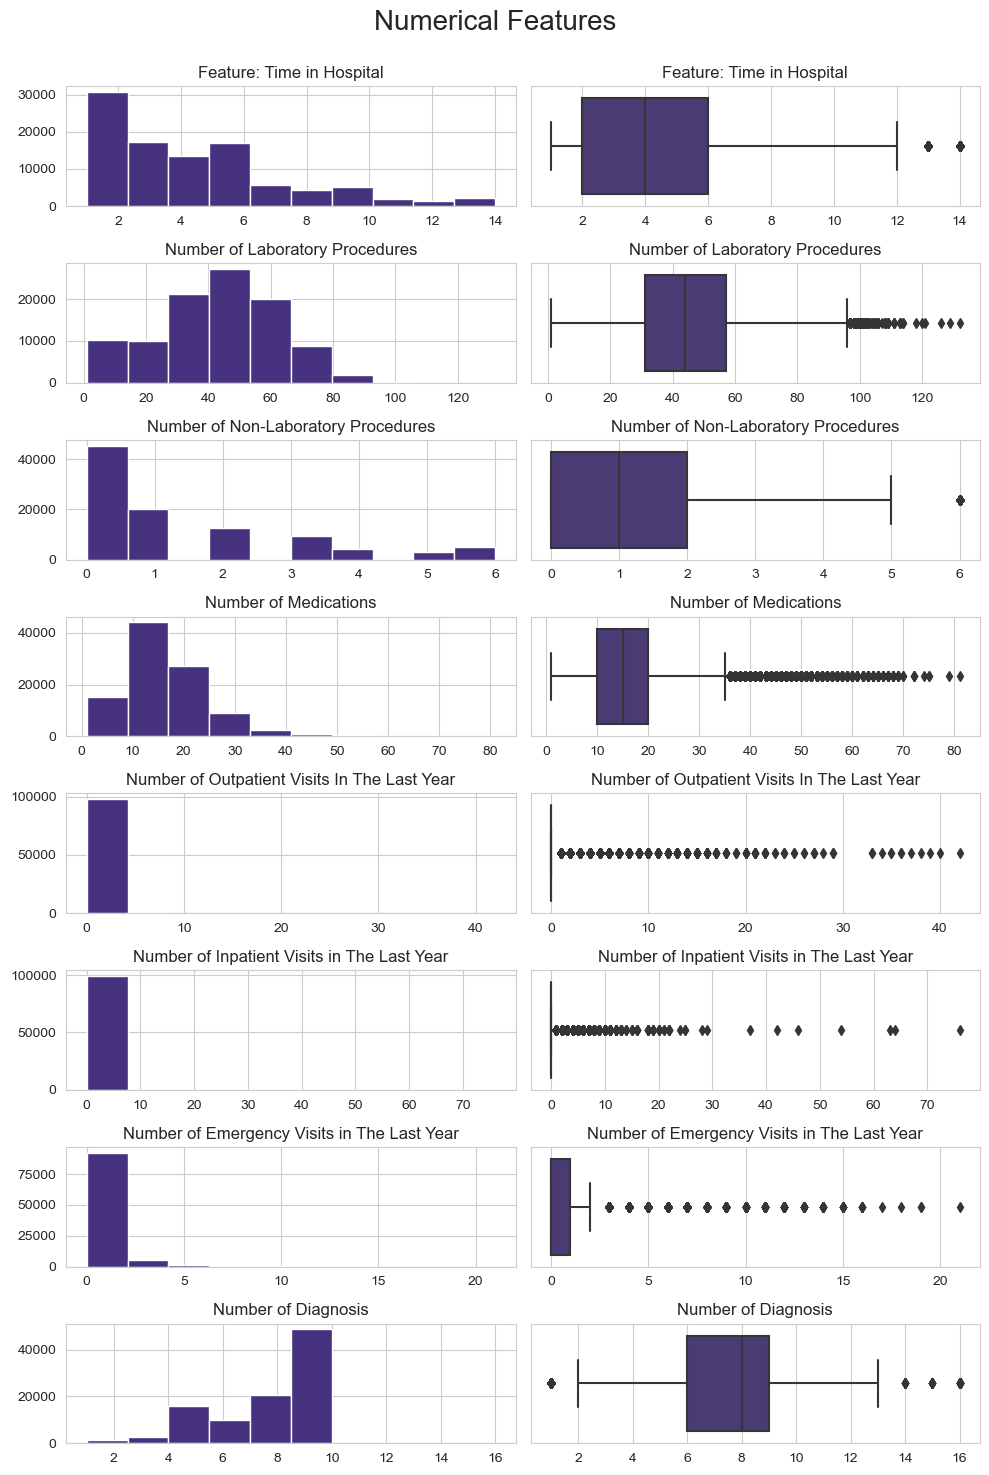

In [250]:
## Univariate Analysis of the numerical features
# Preparing titles
titles = ['Feature: Time in Hospital', 'Number of Laboratory Procedures', 'Number of Non-Laboratory Procedures',
          'Number of Medications', 'Number of Outpatient Visits In The Last Year', 'Number of Inpatient Visits in The Last Year',
          'Number of Emergency Visits in The Last Year', 'Number of Diagnosis']

# Visualizing histograms and boxplots for Numerical features
plt.subplots(8, 2, figsize = (10, 15))
plt.suptitle("Numerical Features", size = 20)
position = 1
title_element = 0

for feature in relevant_numerical_features:
    # Histograms
    plt.subplot(8, 2, position)
    plt.hist(x = numerical_high_instance_df[feature])
    plt.title(titles[title_element])
    position +=1
    
    # Boxplots
    plt.subplot(8, 2, position)
    sns.boxplot(x = numerical_high_instance_df[feature].dropna())
    plt.title(titles[title_element])
    plt.xlabel("")
    position += 1

    title_element += 1
plt.tight_layout(rect=[0, 0, 1, 0.98])

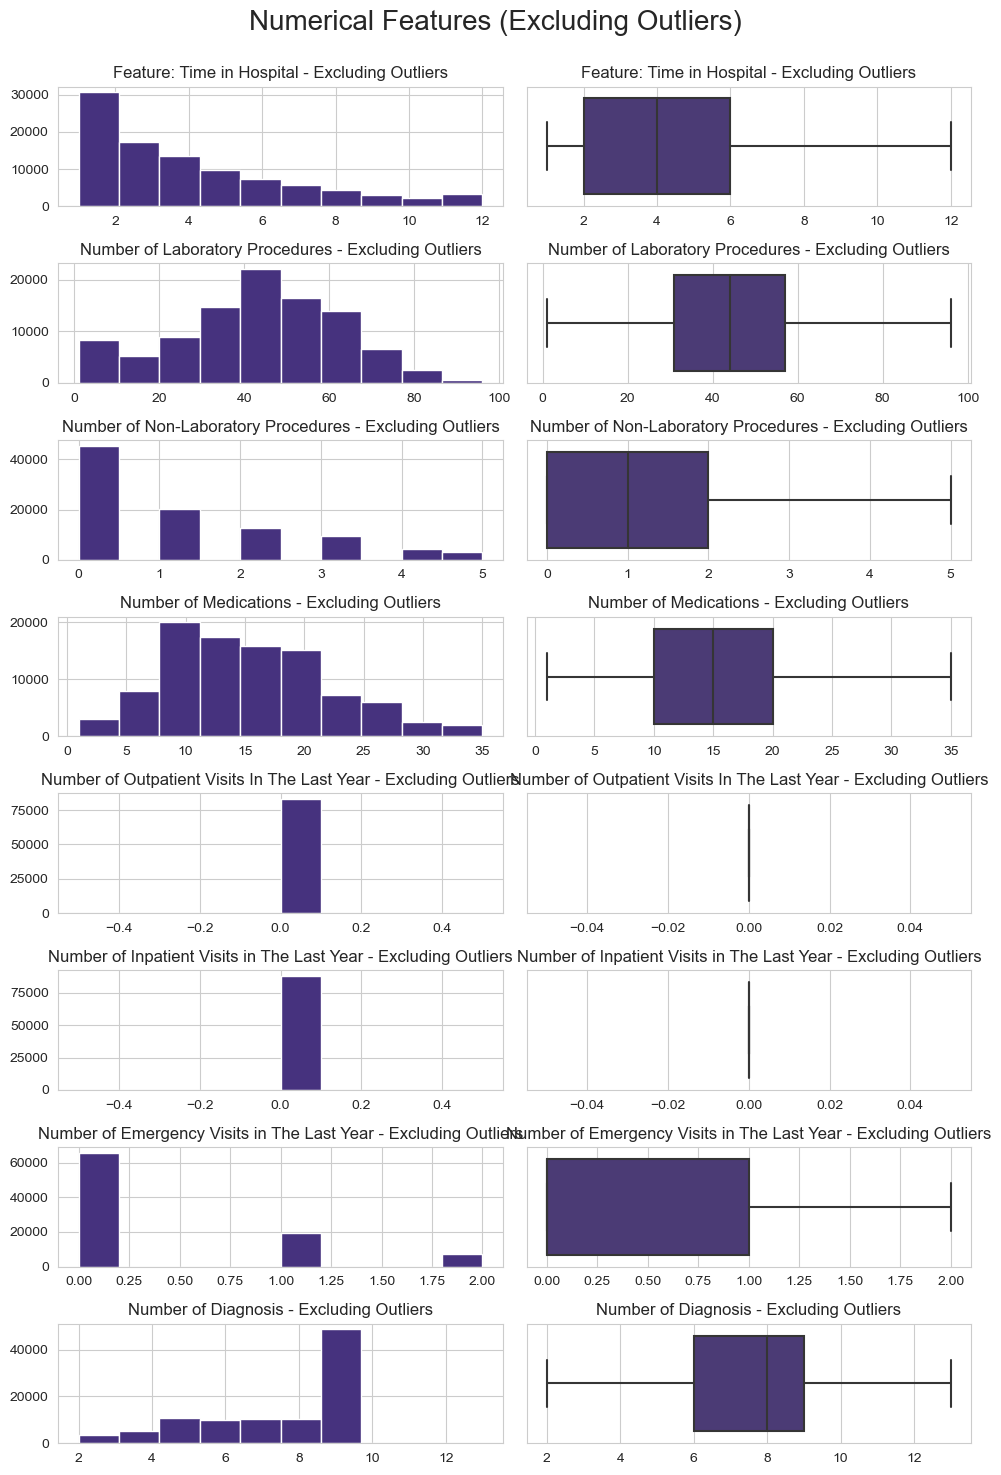

In [252]:
## Visualizing histograms and boxplots for Numerical features excluding outliers feature by feature to understand the shape of
# each more clearly
plt.subplots(8, 2, figsize = (10, 15))
plt.suptitle("Numerical Features (Excluding Outliers)", size = 20)
position = 1
title_element = 0

for feature in relevant_numerical_features:
    # Detecting outliers via Interquartile range
    iqr = numerical_high_instance_df[feature].quantile(0.75) - numerical_high_instance_df[feature].quantile(0.25)
    upper_outlier = numerical_high_instance_df[feature].quantile(0.75) + (iqr*1.5)
    lower_outlier = numerical_high_instance_df[feature].quantile(0.25) - (iqr*1.5)
    condition = (numerical_high_instance_df[feature] <= upper_outlier) & (numerical_high_instance_df[feature] >= lower_outlier)
    high_inst_exclude_outlier = numerical_high_instance_df.loc[condition, feature]
    
    # Visualizing bulk of data more clearly 
    # Histograms
    plt.subplot(8, 2, position)
    plt.hist(x = high_inst_exclude_outlier)
    plt.title(titles[title_element] + ' - Excluding Outliers')
    position += 1

    # Bosplots
    plt.subplot(8, 2, position)
    sns.boxplot(x = high_inst_exclude_outlier)
    plt.title(titles[title_element] + ' - Excluding Outliers')
    plt.xlabel('')
    position += 1

    title_element += 1
plt.tight_layout(rect=[0, 0, 1, 0.98])

The question of removing outliers is always difficult. In this context, the outliers may hold information relevant to clustering patterns of bias and the more complex models are insensitive to them. On the other hand, the simple models are sensitive to them. It is unlikley that the simple models will be able to detect the patterns we seek given the expected variability in the data will likely produce some non-spherical cluster shapes. For these reasons, outliers will not be excluded. 

Aside from the number of lab procedures, these discrete variables would not approximate a normal distribution well given the above visuals, hence the selection of the MinMaxScaler to normalize instead of standardize below. These features are observed to be skewed one way or another, but appear to be unimodal. 

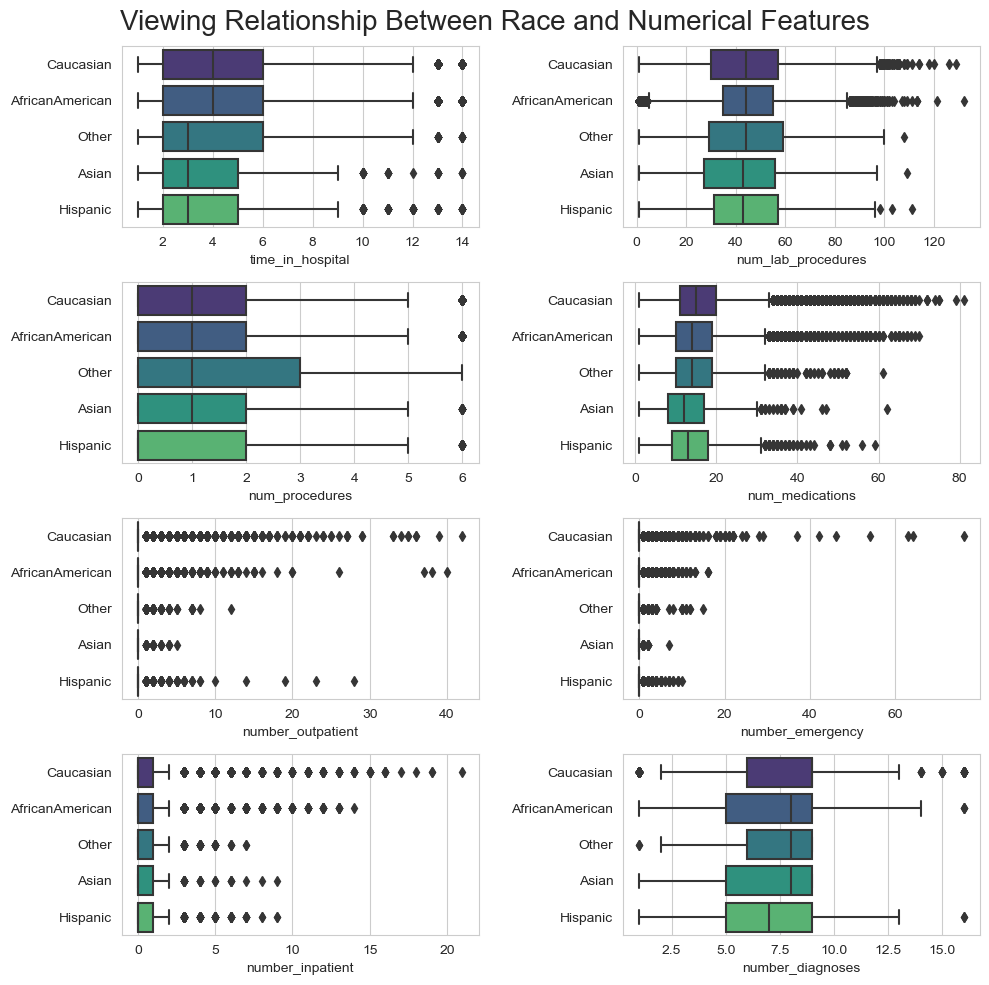

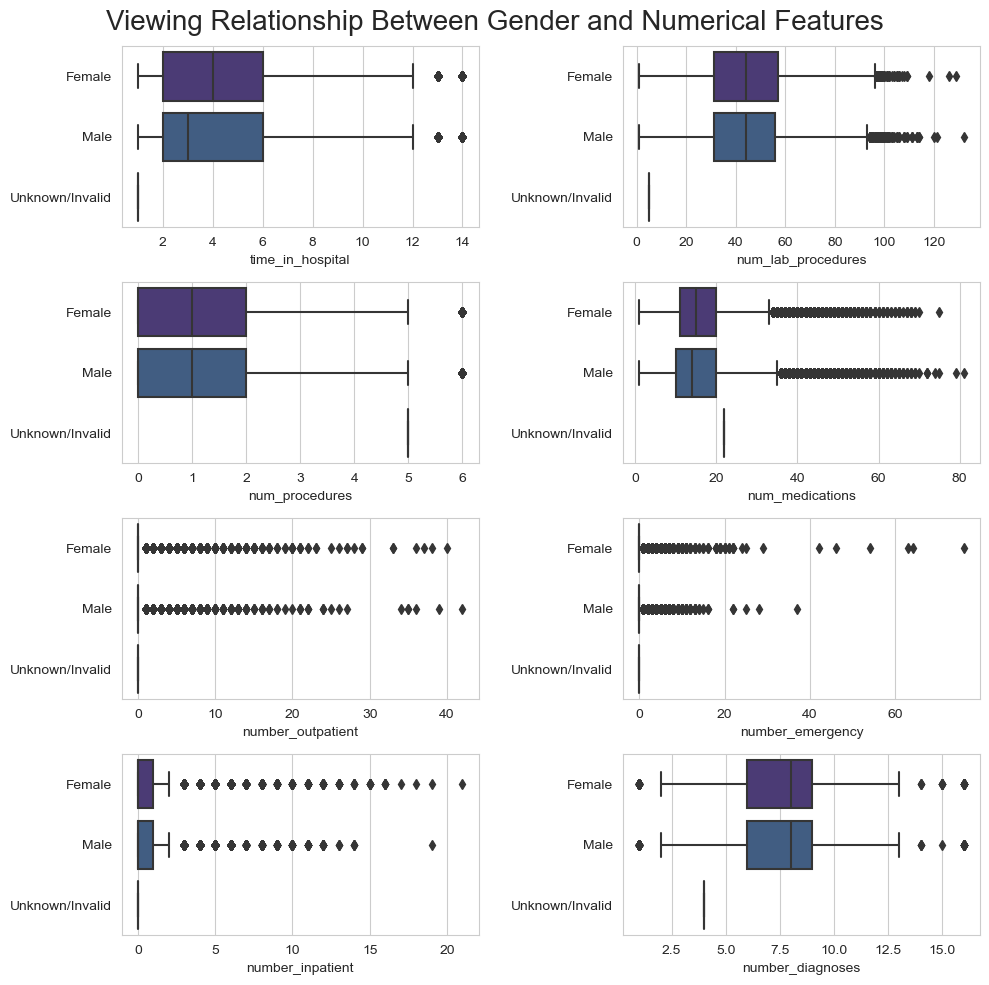

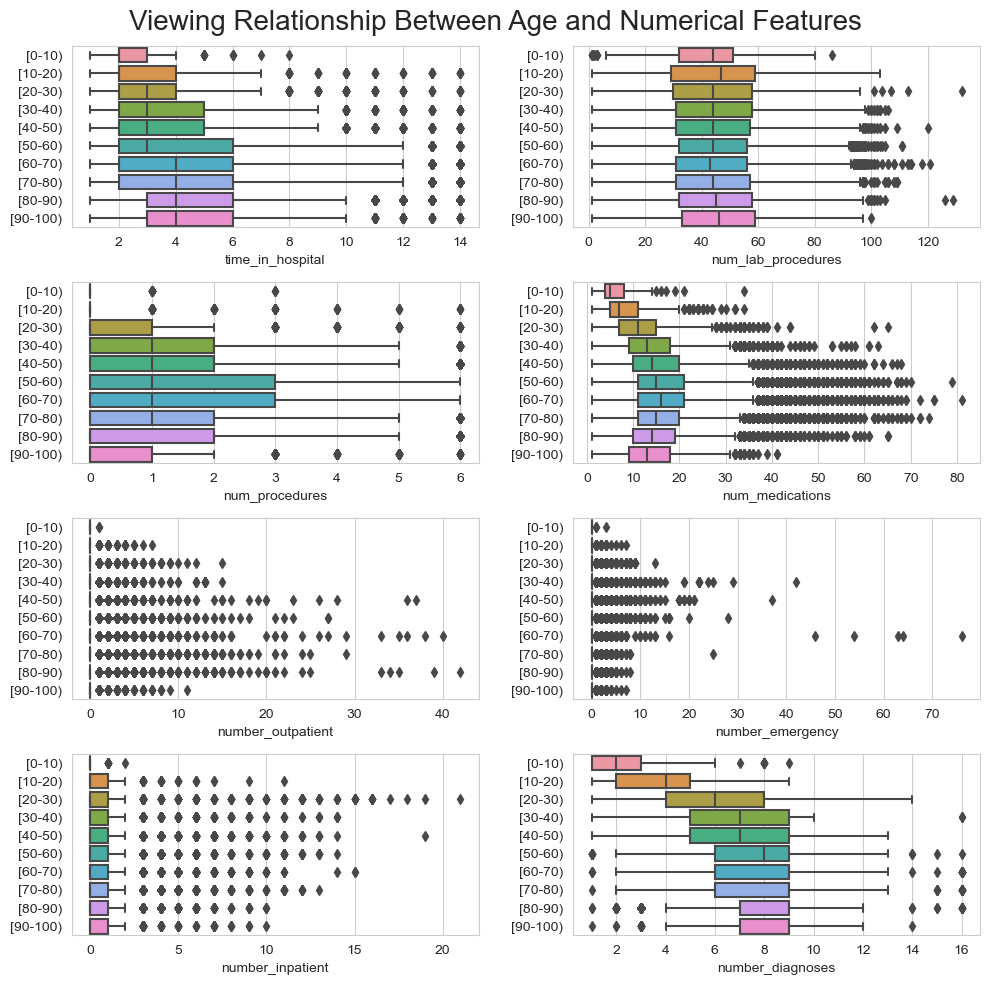

In [253]:
# Viewing associations between identity features and numerical features (Box plot)
## Visualizing numerical feature relationship with race
plt.subplots(4, 2, figsize = (10, 10))
plt.suptitle("Viewing Relationship Between Race and Numerical Features", size = 20)
position = 1
for i in range(0, 8, 1):
    plt.subplot(4, 2, position)
    sns.boxplot(x = numerical_high_instance_df[relevant_numerical_features[position-1]].dropna(), y = numerical_high_instance_df['race'])
    plt.tight_layout()
    plt.ylabel('')
    position += 1

# Visualizing numerical feature relationship with gender
plt.subplots(4, 2, figsize = (10, 10))
plt.suptitle("Viewing Relationship Between Gender and Numerical Features", size = 20)
position = 1
for i in range(0, 8, 1):
    plt.subplot(4, 2, position)
    sns.boxplot(x = numerical_high_instance_df[relevant_numerical_features[position-1]].dropna(), y = numerical_high_instance_df['gender'])
    plt.tight_layout()
    plt.ylabel('')
    position += 1

# Visualizing numerical feature relationship with age
plt.subplots(4, 2, figsize = (10, 10))
plt.suptitle("Viewing Relationship Between Age and Numerical Features", size = 20)
position = 1
for i in range(0, 8, 1):
    plt.subplot(4, 2, position)
    sns.boxplot(x = numerical_high_instance_df[relevant_numerical_features[position-1]].dropna(), y = numerical_high_instance_df['age'])
    plt.tight_layout()
    plt.ylabel('')
    position += 1

### Feature selection

The following features have been selected, for explanation please refer to the research proposal and literature review.
- Admission type
- Discharge disposition
- Admission source
- Time in hospital
- Medical speciality (missing values)
- Payer_code (missing values)
- Num lab procedures
- Num procedures
- Num_medications
- Number inpatient
- Number_diagnoses
- Change
- DiabetesMed

Specific medication (without knowing their price) are not all that informative. 

In [254]:
# Working with a copies for safety
X = high_instances_df.iloc[:, 3:].copy()
x = low_instances_df.iloc[:, 3:].copy()

## Preparing feature groups for preprocessing
# Numerical cols have outliers, will use robust scaler
num_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
            'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# One-hot encode category features
cat_cols = ['admission_type_id', 'discharge_disposition_id']
cat_cols_low = ['admission_type_id', 'discharge_disposition_id', 'payer_code','medical_specialty']

# Remaining features have already been made binary
bi_cols = ['change', 'diabetesMed', 'readmitted']

# Assigning preprocessing requirements
preprocessor_high = ColumnTransformer(transformers = [('num', preprocessing.RobustScaler(), num_cols),
                                                 ('cat', preprocessing.OneHotEncoder(sparse_output = False), cat_cols)],
                                 remainder = 'passthrough')

preprocessor_low = ColumnTransformer(transformers = [('num', preprocessing.RobustScaler(), num_cols),
                                                 ('cat', preprocessing.OneHotEncoder(sparse_output = False), cat_cols_low)],
                                 remainder = 'passthrough')


# Preprocessing accordingly
prepro_high_inst_X = preprocessor_high.fit_transform(X)
prepro_low_inst_x = preprocessor_low.fit_transform(x)

# Getting categorical column names
onehot_feature_names = preprocessor_high.named_transformers_['cat'].get_feature_names_out(cat_cols)
onehot_feature_names_low = preprocessor_low.named_transformers_['cat'].get_feature_names_out(cat_cols_low)

# Getting all column names 
all_col_names = num_cols + list(onehot_feature_names) + bi_cols
all_col_names_low = num_cols + list(onehot_feature_names_low) + bi_cols

# Converting to a DataFrame with column names assigned
prepro_high_inst_X_df = pd.DataFrame(prepro_high_inst_X, columns = all_col_names)
prepro_low_inst_X_df = pd.DataFrame(prepro_low_inst_x, columns = all_col_names_low)

# Viewing dataframe
prepro_high_inst_X_df.head()

time_in_hospital num_lab_procedures num_procedures num_medications  \
0            -0.75          -0.115385           -0.5            -1.4   
1            -0.25           0.576923           -0.5             0.3   
2             -0.5          -1.269231            2.0            -0.2   
3             -0.5                0.0            0.0             0.1   
4            -0.75           0.269231           -0.5            -0.7   

  number_outpatient number_emergency number_inpatient number_diagnoses  \
0               0.0              0.0              0.0        -2.333333   
1               0.0              0.0              0.0         0.333333   
2               2.0              0.0              1.0        -0.666667   
3               0.0              0.0              0.0        -0.333333   
4               0.0              0.0              0.0             -1.0   

  admission_type_id_1 admission_type_id_2 admission_type_id_3  \
0                 0.0                 0.0                 0.0   
1                 1.0                 0.0                 0.0   
2                 1.0                 0.0                 0.0   
3                 1.0                 0.0                 0.0   
4                 1.0                 0.0                 0.0   

  admission_type_id_4 admission_type_id_5 admission_type_id_6  \
0                 0.0                 0.0                 1.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

  admission_type_id_7 admission_type_id_8 discharge_disposition_id_1  \
0                 0.0                 0.0                        0.0   
1                 0.0                 0.0                        1.0   
2                 0.0                 0.0                        1.0   
3                 0.0                 0.0                        1.0   
4                 0.0                 0.0                        1.0   

  discharge_disposition_id_2 discharge_disposition_id_3  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

  discharge_disposition_id_4 discharge_disposition_id_5  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

  discharge_disposition_id_6 discharge_disposition_id_7  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

  discharge_disposition_id_8 discharge_disposition_id_9  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

  discharge_disposition_id_10 discharge_disposition_id_11  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

  discharge_disposition_id_12 discharge_disposition_id_13  \
0                         0.0                         0.0   


#### Principle Component Analysis


Explained Variance: [2.15144199e-01 1.65260132e-01 1.38997071e-01 8.51961067e-02
 7.74205944e-02 5.09329397e-02 4.15935975e-02 3.94527332e-02
 2.99183205e-02 2.79522407e-02 2.61659361e-02 2.52517405e-02
 1.81142787e-02 1.45439334e-02 1.11496755e-02 8.08757410e-03
 6.17638907e-03 5.03944911e-03 3.15355961e-03 2.23577702e-03
 1.88137356e-03 1.40227116e-03 1.01801423e-03 8.52099545e-04
 7.18457791e-04 5.10315006e-04 4.47096983e-04 4.21016747e-04
 4.19426964e-04 1.65823092e-04 1.25753885e-04 7.47904989e-05
 5.61400010e-05 2.64950792e-05 2.49188914e-05 1.65254599e-05
 1.28345061e-05 1.25184901e-05 9.34088052e-06 6.98442837e-06
 5.76665250e-06 3.47814515e-06 2.31086043e-06 0.00000000e+00
 0.00000000e+00]


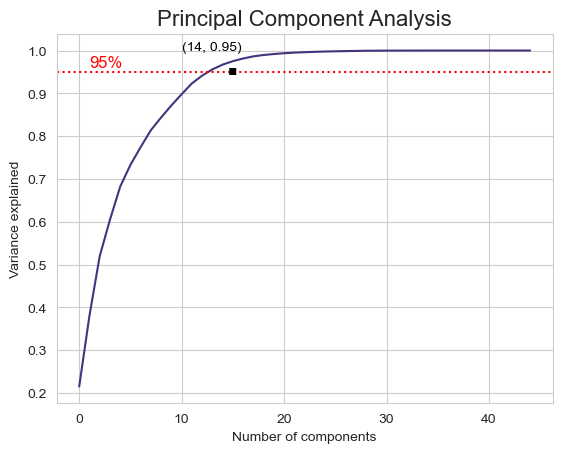


The number of components needed to explain 95% of the variance is 14


In [255]:
# Performing PCA
pca = PCA(n_components = 45, random_state = 42) # There are 45 Features in this dataset, so the maximm number of components is 45
fit = pca.fit(prepro_high_inst_X_df)

# Printing explained variance ratio
print(f"\nExplained Variance: {fit.explained_variance_ratio_}")

# Plotting explained variance with line intersecting at explained variance of 0.95
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.95, linestyle = ':', c = 'r')
plt.title('Principal Component Analysis', size = 16)
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.annotate("95%", xy = (1, 0.96), fontsize = 12, color='r')
plt.annotate("(14, 0.95)", xy = (10, 1), fontsize = 10, color = 'black')
plt.annotate(".", xy = (14, 0.945), fontsize = 50, color = 'black')
plt.show()

# Repreating to verify 14 components can explaining 95% of the variance
pca = PCA(0.95, random_state = 42)
pca.fit(prepro_high_inst_X_df)
reduced = pca.transform(prepro_high_inst_X_df)
print(f"\nThe number of components needed to explain 95% of the variance is {pca.n_components_}")

Early conceptualizations of this process involved dimensionality reduction through principle component analysis to retain inforamtion but filter out noise. These PCs contain information from 'collapsed' dimensions in the data space in a manner that captures majority of the variance but at the cost of simplicity. That is to say, what PC1 values represent specifically is not entirely clear. 

In [256]:
# Principle Component loading scores
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
                        columns = [f'PC{i + 1}' for i in range(pca.n_components_)],
                        index = prepro_high_inst_X_df.columns)
                       
# Sorting values from PC1 and PC2
PC1_loadings = loadings[['PC1']].sort_values(by = 'PC1', ascending = False)
PC2_loadings = loadings[['PC2']].sort_values(by = 'PC2', ascending = False)

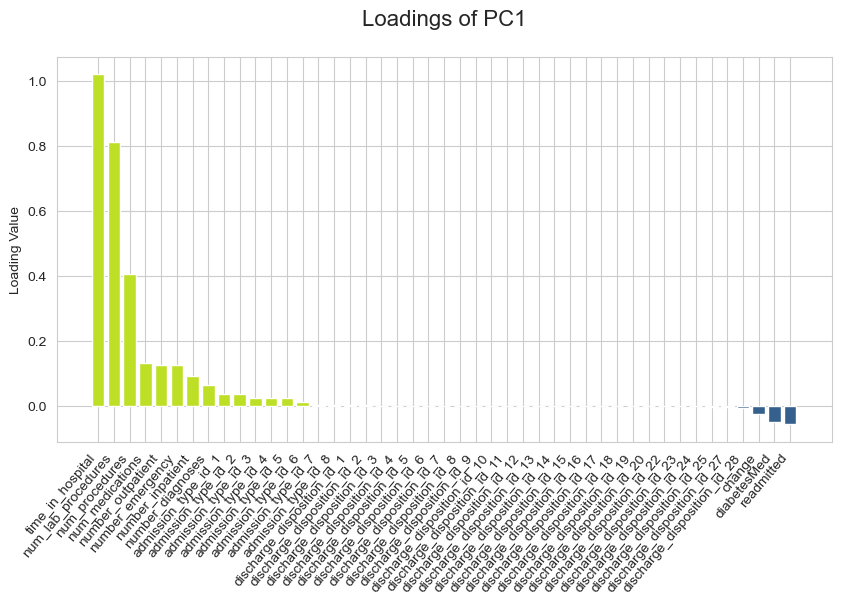

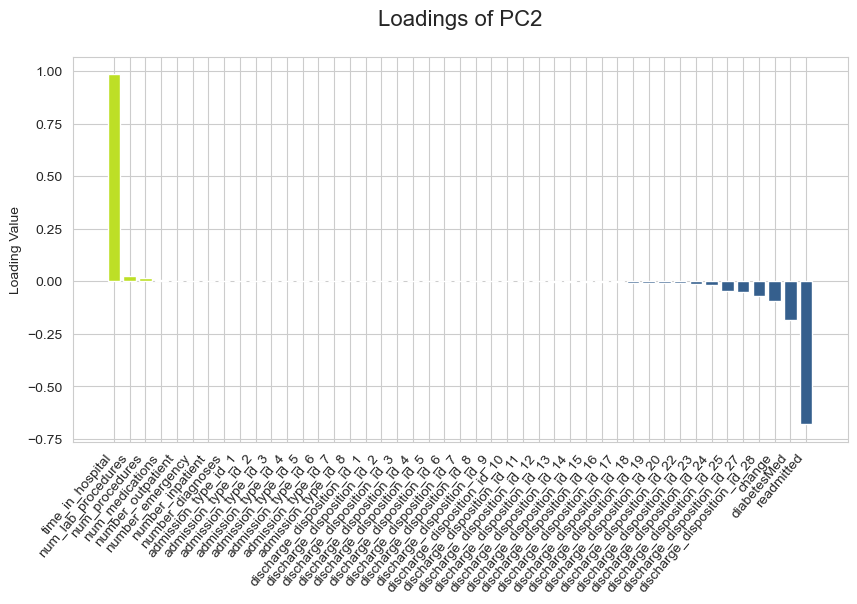

In [257]:
# Principle Component 1 loading scores 
plt.figure(figsize = [10,5])
plt.bar(loadings.index, PC1_loadings.PC1, 
        color = [plt.cm.viridis(0.9) if x > 0 else plt.cm.viridis(0.3) for x in PC1_loadings.PC1]) 
plt.xticks(rotation = 50, ha = 'right')
plt.ylabel('Loading Value')
plt.title('Loadings of PC1\n', size = 16)
plt.show()

# Principle Component 2 loading scores
plt.figure(figsize = [10,5])
plt.bar(loadings.index, PC2_loadings.PC2,
        color = [plt.cm.viridis(0.9) if x > 0 else plt.cm.viridis(0.3) for x in PC1_loadings.PC1])
plt.xticks(rotation = 50, ha = 'right')
plt.ylabel('Loading Value')
plt.title('Loadings of PC2\n', size = 16)
plt.show()

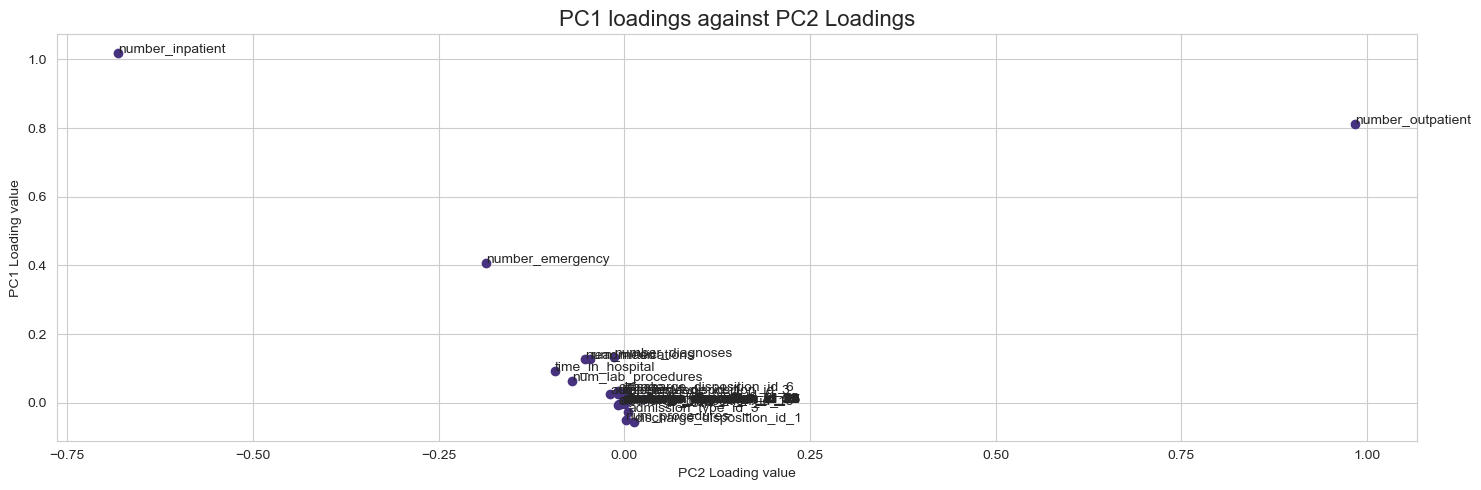

In [258]:
# Scatterplot of PC1 and PC2 loading scores
fig, ax = plt.subplots(figsize = [15,5])
plt.scatter(loadings.PC2, loadings.PC1)
plt.ylabel('PC1 Loading value')
plt.xlabel('PC2 Loading value')
plt.title('PC1 loadings against PC2 Loadings', size = 16)
for i, txt in enumerate(loadings.index):
    ax.annotate(txt, (loadings.PC2[i], loadings.PC1[i]), fontsize = 10)
plt.tight_layout()
plt.show()

The loading plot reveals a cluster of one-hot encoded variables close to eachother, but it is no surprise that these are correlated with one another. The greater the distance between variables in the loading plot, the less correlated they are. Dimensionality reduction has captured 95% of the variables in only 14 components as opposed to the original 45. Sacrificing some information in this manner both removes noise, but also the ability to find weak patterns. This may add greater weight to any clusters that are observed when components are used in place of variables as only the stronger patterns are able to be detected. Any patterns observed by the clustering model are therefore more significant as they have persisted through the hurdle of PCA.

It has been noted that the loading scores in this model are close to the origin, however that does not necessarily mean they are not meaningful.


In [259]:
# Observing the principle components that explain 95% of the variance for each instance 
pca_columns = []
for n in range(0, 14):
    pca_columns.append(f'PC {n+1}')

# Assigning variable to dataframe of PC transformed data
high_inst_pca_df = pd.DataFrame(reduced, columns = pca_columns)
print('The below data set provides a compressed version of the high instance dataset capturing 95% of the variance with 14 Features instead of 45:')
high_inst_pca_df

The below data set provides a compressed version of the high instance dataset capturing 95% of the variance with 14 Features instead of 45:


PC 1      PC 2      PC 3      PC 4      PC 5      PC 6      PC 7  \
0     -1.184002  0.270121 -1.998580 -0.118890  0.188236  0.702478 -0.728753   
1     -0.594415  0.036596  0.006527 -0.134504 -1.026095  0.107550 -0.242031   
2      0.855756  1.298386 -0.181474  0.092297  2.106817  0.730108  0.317747   
3     -0.828261  0.143245 -0.307255  0.038083 -0.187032  0.237174 -0.496703   
4     -0.950991  0.187963 -1.194424 -0.101939 -0.489323  0.610464 -0.868352   
...         ...       ...       ...       ...       ...       ...       ...   
99488 -0.568144  0.049718 -0.061160 -0.193826 -1.056409 -0.441996  0.170740   
99489 -0.003780 -0.467435  0.544436 -0.161200  0.501375 -0.024348  0.832149   
99490 -0.101415  0.957280 -0.570890 -0.185693 -0.972813  0.145051  0.890300   
99491  0.167212 -0.602756  1.377942 -0.258222 -0.134900 -0.915576  0.191001   
99492 -0.950098  0.198996 -0.534245  0.159235  0.777367  0.165230  1.556205   

           PC 8      PC 9     PC 10     PC 11     PC 12     PC 13     PC 14  
0      1.580457  0.322151 -0.625587 -0.806133  0.182550 -0.042206  0.029863  
1     -1.085579 -0.223715  0.207196  0.236582  0.353332  0.064754  0.001186  
2     -0.049644  0.911735  0.736351  0.095299 -0.362788 -0.319284  0.012940  
3     -0.727002  0.324077  0.224796  0.034352 -0.453447 -0.087751 -0.019100  
4     -0.314733  0.218599  0.292633 -0.227341 -0.405551  0.042643 -0.014340  
...         ...       ...       ...       ...       ...       ...       ...  
99488 -0.748944  0.070626  0.203568 -0.726241  0.441219 -0.004119  0.682852  
99489 -0.130817  0.681001  0.194003 -0.196160 -0.408095 -0.167557 -0.063516  
99490 -1.675252 -0.535881  0.184132  0.021466 -0.901284  0.364464 -0.064722  
99491  0.626292 -0.657310  0.289553 -0.420648 -0.776233 -0.479370  0.568204  
99492  0.456960  0.310468  0.897280  0.624907 -0.543056  0.143352 -0.069442  

[99493 rows x 14 columns]

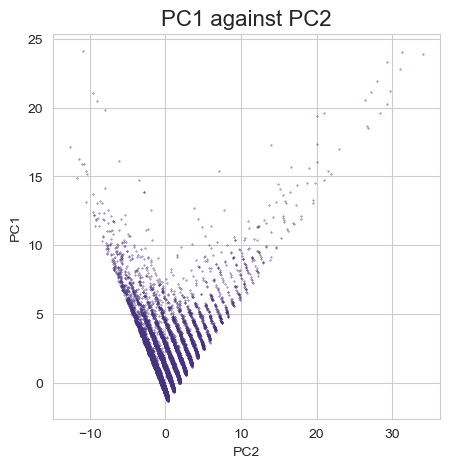

In [260]:
# Plotting instance components against each other
# Scatterplot of PC1 and PC2
fig, ax = plt.subplots(figsize = [5, 5])
plt.scatter(high_inst_pca_df["PC 2"], high_inst_pca_df["PC 1"], s = 0.1)
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.title('PC1 against PC2', size = 16)
plt.show()

### UMAP
UMAP is an alternate dimensionality reduction technique that preserves local structures well and can result in better clustering of local structures.

it relies on:
- Abstract simplecial complexes - abstract shapes that generalise space.
- Nerve theorem - basically states that a nerve (a finite subcollection of any non-trivial intersection with a subset) and the union of the sets have the same homotopy type (that is that they both have a function that can connect the same two points). This is important here because it allows us to connect simplicial complexes and create topological spaces, effectively capturing local structures/information in a compressed way.
- Riemannian metric - As data is not normally distributed perfectly the topological spaces found using nerve theroem are not fully connected. To fix this we make the assumption that the data actually is normally distributed (but on a curved space) by introducing a Riemannian metric. In essence, it defines a notion of distance that varies from point to point so that each local patch of simplicial complex can 'reach' it's neighbouring simplicial complex and 'fuse' to form a long nerve along the whole dataset. In doing this, the manifold is established.
- Moving from finite metric space to fuzzy simplecial sets - this decays confidence of overlap between sets in this new Reimannian metric paradigm so that the further out the overlap the less sure you are of it.
- The edges between sets are used to mathematically define the probability of the edge existing, with cross entropy used to optimise.
- The equation itself essentially seeks to get the 'clumps' right and then to get the 'gaps' right. The result is that pockets of density tend to seperate from other pockets of desnity creating groups in the embedded data that follow from the patterns seen in the original high dimensional space.

The above math is complex, but it provides the mathematical framework to support the low dimensional graph view of the dataset. 

In [234]:
## Visual selection followed up by a parameter robustness/ stability analysis check
# Preparing image and parmater lists
plt.figure(figsize = (10, 200))
n_neigh = [12, 15 , 17]#Tested [5, 15, 30, 60, 120]
min_dist = [0.03, 0.04, 0.05, 0.06, 0.07]#tested [0.1, 0.5, 1]
n_comp = [2] #tested[2, 5, 10]

position = 1
# Trialing combinations of above
for n in n_neigh:
    for dist in min_dist:
        for comp in n_comp:
            # For some reason the module needs to be reloaded with each call for umap()
            import umap.umap_ as umap
            
            # Initilizing UMAP model
            umap_ = umap.UMAP(n_neighbors = n, # Balances local vs global structures when making he manifold 
                             min_dist = dist, # Indicates how tightly points can be packed together, tighter is better suited (<1) 
                             n_components = comp, 
                             random_state = 42)

            # Embedding data
            reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)
            
            # Assigning embedded data dataframe to variable
            high_umap_df = pd.DataFrame(reduced_umap, 
                                    columns = [f'C{i + 1}' for i in range(0, umap_.n_components)])
    
            # Scatterplot of PC1 and PC2
            plt.subplot(45, 1, position) 
            plt.scatter(high_umap_df["C2"], high_umap_df["C1"], s = 0.1)
            plt.ylabel('C1')
            plt.xlabel('C2')
            plt.title(f'UMAP - n-neighbours = {n}, min_dist = {dist}, n_components = {comp}' , size = 16)
            position += 1


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000022A5E2A9D80> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x0000022A6E463400> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



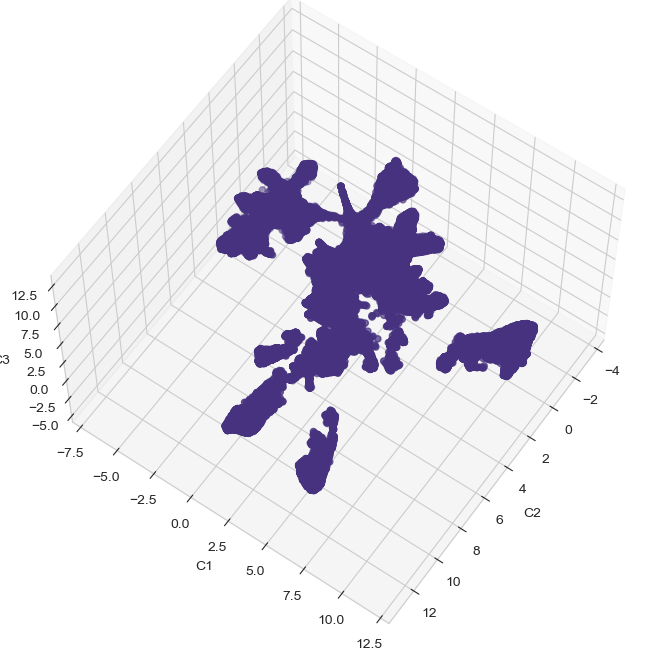

In [27]:
# Testing UMAP on three dimensions
umap_ = umap.UMAP(n_components = 3, random_state = 42)

# Embedding data
reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

# Assigning embedded data dataframe to variable
high_umap_df = pd.DataFrame(reduced_umap, 
                        columns = [f'C{i + 1}' for i in range(0, umap_.n_components)])

# Scatterplot of PC1 and PC2
fig = plt.figure(figsize = [8,8])
ax = plt.axes(projection = '3d')
ax.scatter3D(high_umap_df["C2"], high_umap_df["C1"], high_umap_df["C3"], marker = 'o')
ax.set_xlabel('C2')
ax.set_ylabel('C1')
ax.set_zlabel('C3')
ax.view_init(60, 35)

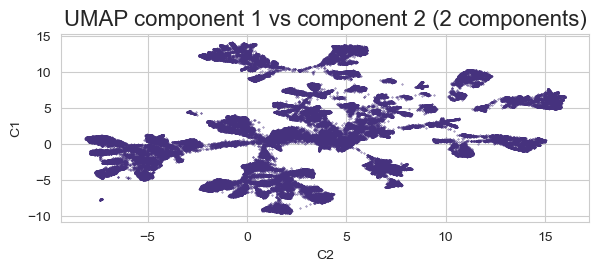

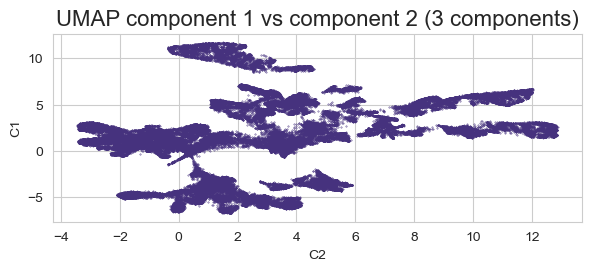

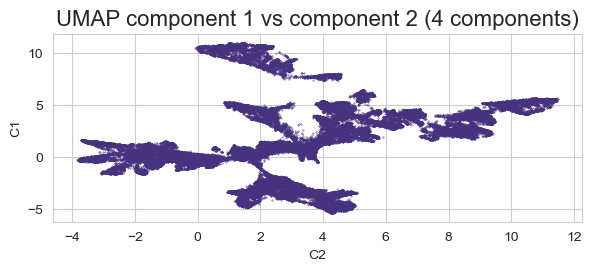

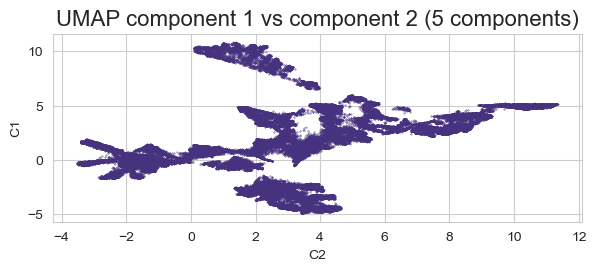

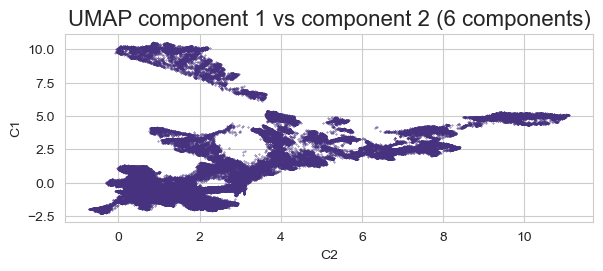

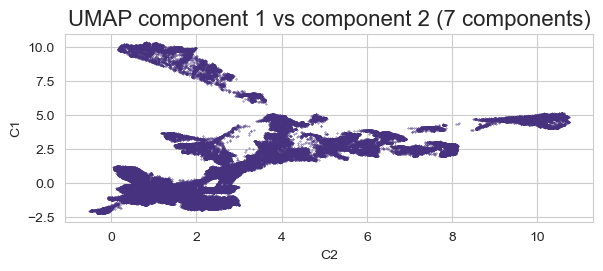

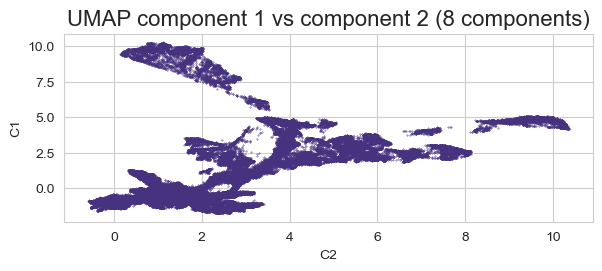

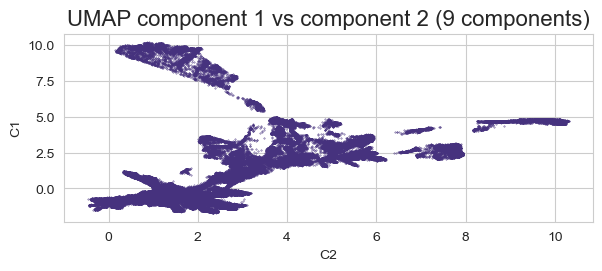

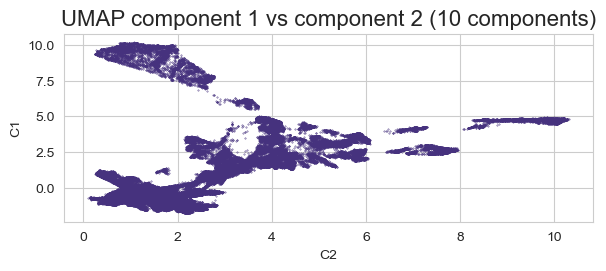

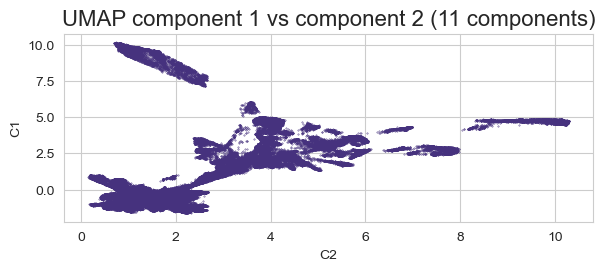

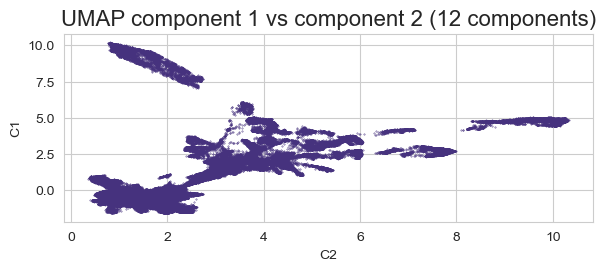

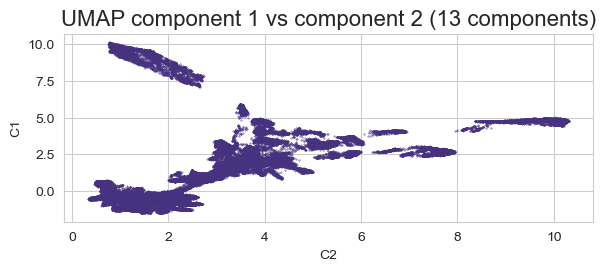

In [28]:
# Assessing impact of n_components on first two components
position = 1
for n in range(2, 14, 1):
    # Initilizing model
    umap_ = umap.UMAP(n_components = n, random_state = 42)
    # Embedding data
    reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

    # PAssigning embedded data dataframe to variable
    high_umap_df = pd.DataFrame(reduced_umap, 
                                columns = [f'C{i + 1}' for i in range(0, umap_.n_components)])
    
    # Plotting figure to obsevere stability as n-components changes
    plt.figure(figsize = [15, 20])
    plt.subplot(7, 2, position)
    plt.scatter(high_umap_df["C2"], high_umap_df["C1"], s = 0.1)
    plt.ylabel('C1')
    plt.xlabel('C2')
    plt.title(f'UMAP component 1 vs component 2 ({n} components)', size = 16)
    position += 1

In [29]:
## UMAP
# Preparing parameters for UMAP tuning
n_neigh = [15] #[5, 14, 15, 16]
min_dist = [0.05] #[0.05, 0.1, 0.15, 0.2]
n_comp = [2]#, 5, 10] # System error - over 48 hours running before force shutdown

# Creating empty DataFrame container to store performence metrics
columns = ['n_neighbours', 'min_dist', 'n_components', 'random_state', 'reconstruction_error', 'duration']
umap_assessment = pd.DataFrame(columns=columns)

index = 0
# Tuning UMAP
for n in n_neigh:
    for dist in min_dist:
        for comp in n_comp:
            # Measuring the time it takes to run this particular combination
            start_time = time.time()
            
            # Building model
            umap_ = umap.UMAP(n_neighbors = n, # Balances local vs global structures when making he manifold 
                             min_dist = dist, # Indicates how tightly points can be packed together, tighter is better suited (<1) 
                             n_components = comp, # The number of components desired
                             random_state = 42,
                             n_jobs = -1)
            
            # Embedding the data with the above UMAP model
            reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

            # Inverse transforming to measure reconstruction error
            reconstructed_umap = umap_.inverse_transform(reduced_umap)
            reconstruction_error = mean_squared_error(prepro_high_inst_X_df, reconstructed_umap)

            # Measuring duration
            end_time = time.time() 
            exe_time = end_time - start_time

            # Recording Output
            umap_assessment.loc[index] = [n, dist, comp, 42, reconstruction_error, exe_time]
            index += 1

            # Saving output
            filename = datetime.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")
            file = f"C:\\Users\\Dylan Rohan\\OneDrive - University of Adelaide\\data_science_research_project\\project_files\\output_files\\ \
            umap_{filename}.csv"
            umap_assessment.to_csv(file)

# Obtaining the best output and viewing output
best_row = umap_assessment['reconstruction_error'].idxmin()
min_mse = min(umap_assessment['reconstruction_error'])
best_parameters = f"n_neighbours ={umap_assessment.at[best_row, 'n_neighbours']}, \
min_dist = {umap_assessment.at[best_row, 'min_dist']}, and \
n_components = {umap_assessment.at[best_row,'n_components']}"
print(f'The best recorded reconstruction error was {min_mse} the set of hyperparameters that acheved this was {best_parameters}')

# Viewing all runs
umap_assessment

The best recorded reconstruction error was 0.04966555372984958 the set of hyperparameters that acheved this was n_neighbours =15.0, min_dist = 0.05, and n_components = 2.0


n_neighbours  min_dist  n_components  random_state  reconstruction_error  \
0          15.0      0.05           2.0          42.0              0.049666   

      duration  
0  1671.427087

In [30]:
# Obtaining embedded data from the tuned UMAP model
umap_ = umap.UMAP(n_neighbors = umap_assessment.at[best_row, 'n_neighbours'],  
                 min_dist = umap_assessment.at[best_row, 'min_dist'],  
                 n_components = umap_assessment.at[best_row,'n_components'],
                 random_state = 42)

# Embedding the data with the above UMAP model
reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

# Storing as a DataFrame
tuned_umap_df = pd.DataFrame(reduced_umap,
                             columns = [f'C{i + 1}' for i in range(0, umap_.n_components)])

In [31]:
# Splitting data into 5 'Validation' sets for stability analysis to determine stability of clusters
kfolds =  model_selection.KFold(n_splits = 5, shuffle = True, random_state = 42)

# Preparing splits for each dataset
prepro_high_inst_splits = list(kfolds.split(prepro_high_inst_X))
prepro_low_inst_splits = list(kfolds.split(prepro_low_inst_x))
pca_high_inst_splits = list(kfolds.split(high_inst_pca_df))
umap_inst_splits = list(kfolds.split(tuned_umap_df))

### Model fitting and evaluation
#### K-means

In [261]:
# Will be repeating multiple times, so creating a function to process each dataset
def K_means_model(K_min, K_max, K_step, splits, dataframe):
    # Recording start time
    start_time = time.time()
    
    # Creating lists to store output
    fold_1_silhouette = []
    fold_2_silhouette = []
    fold_3_silhouette = []
    fold_4_silhouette = []
    fold_5_silhouette = []

    fold_1_distortion = []
    fold_2_distortion = []
    fold_3_distortion = []
    fold_4_distortion = []
    fold_5_distortion = []

    # Assigning how many clusters
    clusters = range(K_min, K_max, K_step) 

    # Testing model on various levels of K
    for k in clusters:
        fold = 1
        # Loop through each fold
        for train, _ in splits:
            # Building model
            model = KMeans(n_clusters = k, 
                            random_state = 42, 
                            algorithm = 'lloyd',  # Large dataset with cluster not exected to be seperated all that well
                            tol = 1e-4,           # Need convergence to be reached, so tolerance needs to be low,
                            max_iter = 300)
    
            # Fit model on given fold
            try: 
                train_set = dataframe.iloc[train]
                model.fit(train_set)
            except AttributeError:
                train_set = dataframe[train]
                model.fit(train_set)
                
            # Measuting distortion
            k_distortion = model.inertia_
            
            # Measuring silhouette scores
            labels = model.labels_
            k_silhouette = silhouette_score(train_set, labels, metric = 'euclidean')
            
            # Saving information about each fold
            if fold == 1:
                fold_1_silhouette.append(k_silhouette)
                fold_1_distortion.append(k_distortion)
                fold += 1
                
            elif fold == 2:
                fold_2_silhouette.append(k_silhouette)
                fold_2_distortion.append(k_distortion)
                fold += 1
                
            elif fold == 3:
                fold_3_silhouette.append(k_silhouette)
                fold_3_distortion.append(k_distortion)
                fold += 1
                
            elif fold == 4:
                fold_4_silhouette.append(k_silhouette)
                fold_4_distortion.append(k_distortion)
                fold += 1
                
            else:
                fold_5_silhouette.append(k_silhouette)
                fold_5_distortion.append(k_distortion)
                fold = 1
    
    # Tabulating results
    results_df = pd.DataFrame({'K': clusters,
                                'Fold 1 - Silhouette scores': pd.Series(fold_1_silhouette),
                                'Fold 2 - Silhouette scores': pd.Series(fold_2_silhouette),
                                'Fold 3 - Silhouette scores': pd.Series(fold_3_silhouette),
                                'Fold 4 - Silhouette scores': pd.Series(fold_4_silhouette),
                                'Fold 5 - Silhouette scores': pd.Series(fold_5_silhouette),
                                'Fold 1 - Distortion': pd.Series(fold_1_distortion),
                                'Fold 2 - Distortion': pd.Series(fold_2_distortion),
                                'Fold 3 - Distortion': pd.Series(fold_3_distortion),
                                'Fold 4 - Distortion': pd.Series(fold_4_distortion),
                                'Fold 5 - Distortion': pd.Series(fold_5_distortion)})
    # Calculating Mean
    results_df['Mean Silhouette score'] =  results_df.iloc[:, 1:6].mean(axis=1) 
    results_df['Mean distortion'] =  results_df.iloc[:, 6:11].mean(axis=1) 

    # Calculating runtime 
    end_time = time.time()
    runtime_kmeans = end_time-start_time
    
    return results_df, runtime_kmeans

In [262]:
# K-Means on high instance dataset 
kmeans_high_inst_results_df, runtime_high_inst = K_means_model(2, 22, 4,   # Setting Range() values
                                                 prepro_high_inst_splits,  # Setting data splits
                                                 prepro_high_inst_X)       # Setting data

# K-means on low instance dataset
kmeans_low__inst_results_df, runtime_low_inst = K_means_model(2, 22, 4,  # Setting Range() values
                                                prepro_low_inst_splits,  # Setting data splits
                                                prepro_low_inst_x)       # Setting data

# K-means on PCA transformed dataset
kmeans_pca_results_df, runtime_pca_trans =  K_means_model(2, 22, 4,  # Setting Range() values
                                            pca_high_inst_splits,    # Setting data splits
                                            high_inst_pca_df)        # Setting data

# K-means on UMAP embedded dataset
kmeans_umap_results_df, runtime_umap_embed = K_means_model(2, 22, 4,  # Setting Range() values
                                             umap_inst_splits,        # Setting data splits
                                             tuned_umap_df)           # Setting data
 


In [263]:
# Viewing K-means output - High instance
print(f'Completed in {round(runtime_high_inst/60, 2)} minutes')
kmeans_high_inst_results_df

Completed in 49.6 minutes


K  Fold 1 - Silhouette scores  Fold 2 - Silhouette scores  \
0   2                    0.367208                    0.369094   
1   6                    0.122277                    0.103570   
2  10                    0.090903                    0.097305   
3  14                    0.091363                    0.088908   
4  18                    0.085774                    0.077960   

   Fold 3 - Silhouette scores  Fold 4 - Silhouette scores  \
0                    0.361912                    0.366434   
1                    0.110444                    0.083396   
2                    0.098461                    0.098890   
3                    0.081892                    0.086948   
4                    0.088412                    0.083328   

   Fold 5 - Silhouette scores  Fold 1 - Distortion  Fold 2 - Distortion  \
0                    0.362439        628250.168263        627847.496241   
1                    0.095510        457017.359170        456940.676120   
2                    0.090226        389826.038226        386761.340540   
3                    0.085743        352131.749990        342933.908572   
4                    0.083034        318932.289514        318584.845312   

   Fold 3 - Distortion  Fold 4 - Distortion  Fold 5 - Distortion  \
0        617838.478071        619609.688583        619565.390272   
1        456512.249205        459672.707284        456724.480837   
2        375653.660005        375882.564934        385602.913079   
3        348477.584402        343943.171802        349953.082094   
4        322302.871446        320295.991033        320657.131307   

   Mean Silhouette score  Mean distortion  
0               0.365418    622622.244286  
1               0.103039    457373.494523  
2               0.095157    382745.303357  
3               0.086971    347487.899372  
4               0.083701    320154.625722

In [264]:
# Viewing K-means output - Low instance
print(f'Completed in {round(runtime_low_inst/60, 2)} minutes')
kmeans_low__inst_results_df

Completed in 4.14 minutes


K  Fold 1 - Silhouette scores  Fold 2 - Silhouette scores  \
0   2                    0.489306                    0.375632   
1   6                    0.095906                    0.080847   
2  10                    0.075196                    0.081622   
3  14                    0.072057                    0.078209   
4  18                    0.066273                    0.076388   

   Fold 3 - Silhouette scores  Fold 4 - Silhouette scores  \
0                    0.467579                    0.087045   
1                    0.085969                    0.079566   
2                    0.080609                    0.064400   
3                    0.067779                    0.070171   
4                    0.071269                    0.065667   

   Fold 5 - Silhouette scores  Fold 1 - Distortion  Fold 2 - Distortion  \
0                    0.378062        209615.692553        213790.116581   
1                    0.087245        159341.769458        163707.234485   
2                    0.082890        138213.232337        136726.377115   
3                    0.080097        125368.615165        123626.941288   
4                    0.068912        119620.037792        117646.869177   

   Fold 3 - Distortion  Fold 4 - Distortion  Fold 5 - Distortion  \
0        215136.854547        228827.429869        215078.097855   
1        161594.665508        160457.376507        162329.034583   
2        136273.952801        137335.486755        136972.599705   
3        126762.151393        122918.355361        125511.959264   
4        116815.777861        116066.641456        119557.735573   

   Mean Silhouette score  Mean distortion  
0               0.359525    216489.638281  
1               0.085907    161486.016108  
2               0.076944    137104.329742  
3               0.073663    124837.604494  
4               0.069702    117941.412372

In [265]:
# Viewing K-means output - PCA transformed
print(f'Completed in {round(runtime_pca_trans/60, 2)} minutes')
kmeans_pca_results_df

Completed in 38.23 minutes


K  Fold 1 - Silhouette scores  Fold 2 - Silhouette scores  \
0   2                    0.379935                    0.382549   
1   6                    0.104041                    0.104767   
2  10                    0.096884                    0.106192   
3  14                    0.102294                    0.102631   
4  18                    0.091912                    0.094759   

   Fold 3 - Silhouette scores  Fold 4 - Silhouette scores  \
0                    0.374785                    0.379227   
1                    0.110435                    0.103618   
2                    0.101628                    0.101125   
3                    0.099303                    0.096330   
4                    0.095429                    0.092664   

   Fold 5 - Silhouette scores  Fold 1 - Distortion  Fold 2 - Distortion  \
0                    0.375272        596655.613713        596356.279046   
1                    0.108936        432346.600807        432313.360683   
2                    0.105041        367158.488926        354374.373711   
3                    0.097248        311834.596944        318093.578673   
4                    0.090516        292438.088993        292745.374164   

   Fold 3 - Distortion  Fold 4 - Distortion  Fold 5 - Distortion  \
0        586314.690148        588117.687598        588000.310142   
1        417856.722348        424297.738672        419145.679197   
2        349950.890481        350572.109851        354081.761349   
3        311511.021593        316440.314823        314646.248668   
4        289307.273452        295719.091030        286014.182585   

   Mean Silhouette score  Mean distortion  
0               0.378354    591088.916129  
1               0.106359    425192.020341  
2               0.102174    355227.524863  
3               0.099561    314505.152140  
4               0.093056    291244.802045

In [266]:
# Viewing K-means output - UMAP embedded
print(f'Completed in {round(runtime_umap_embed/60, 2)} minutes')
kmeans_umap_results_df

Completed in 42.19 minutes


K  Fold 1 - Silhouette scores  Fold 2 - Silhouette scores  \
0   2                    0.420092                    0.419136   
1   6                    0.470405                    0.456551   
2  10                    0.468345                    0.495332   
3  14                    0.475492                    0.482306   
4  18                    0.477190                    0.475772   

   Fold 3 - Silhouette scores  Fold 4 - Silhouette scores  \
0                    0.419357                    0.418948   
1                    0.457858                    0.488681   
2                    0.453260                    0.477324   
3                    0.481560                    0.475006   
4                    0.497662                    0.457974   

   Fold 5 - Silhouette scores  Fold 1 - Distortion  Fold 2 - Distortion  \
0                    0.419490         2.638181e+06         2.645082e+06   
1                    0.462301         7.491504e+05         7.237609e+05   
2                    0.468221         3.761460e+05         3.740334e+05   
3                    0.486055         2.193298e+05         2.175048e+05   
4                    0.501139         1.654351e+05         1.711523e+05   

   Fold 3 - Distortion  Fold 4 - Distortion  Fold 5 - Distortion  \
0         2.645464e+06         2.641562e+06         2.642327e+06   
1         7.231736e+05         7.062006e+05         7.282457e+05   
2         3.862071e+05         4.043753e+05         3.774985e+05   
3         2.176236e+05         2.201789e+05         2.376146e+05   
4         1.566018e+05         1.787007e+05         1.765304e+05   

   Mean Silhouette score  Mean distortion  
0               0.419405     2.642523e+06  
1               0.467159     7.261063e+05  
2               0.472497     3.836521e+05  
3               0.480084     2.224503e+05  
4               0.481948     1.696840e+05

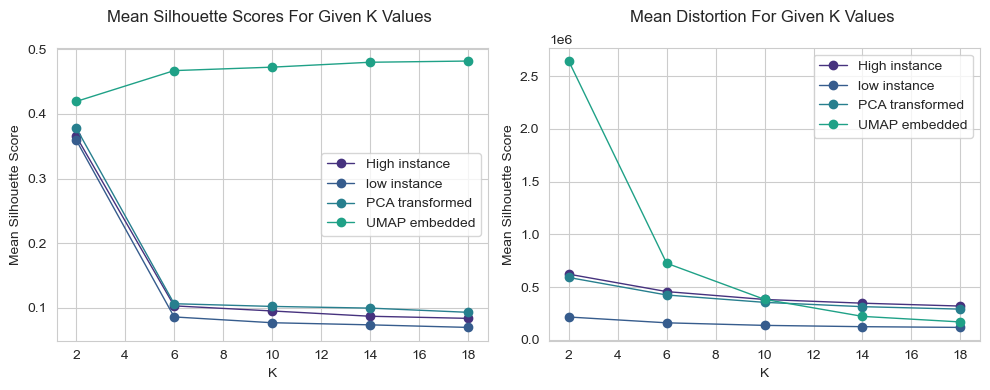

In [267]:
## Compiling Data
# Setting K as the index
kmeans_high_inst_results_df.set_index('K', inplace = True)
kmeans_low__inst_results_df.set_index('K', inplace = True)
kmeans_pca_results_df.set_index('K', inplace = True)
kmeans_umap_results_df.set_index('K', inplace = True)

# Compiling scores for each K
k_means_results = pd.concat([kmeans_high_inst_results_df[['Mean Silhouette score']].add_suffix('_high_inst'),
                            kmeans_low__inst_results_df[['Mean Silhouette score']].add_suffix('_low_inst'),
                            kmeans_pca_results_df[['Mean Silhouette score']].add_suffix('_pca_trans'),
                            kmeans_umap_results_df[['Mean Silhouette score']].add_suffix('_umap_embed')], axis = 1)

k_means_results_distortion = pd.concat([kmeans_high_inst_results_df[['Mean distortion']].add_suffix('_high_inst'),
                                        kmeans_low__inst_results_df[['Mean distortion']].add_suffix('_low_inst'),
                                        kmeans_pca_results_df[['Mean distortion']].add_suffix('_pca_trans'),
                                        kmeans_umap_results_df[['Mean distortion']].add_suffix('_umap_embed')], axis = 1)

## Plotting an elbow curve to compare models
# Silhouette score elbow curve
plt.figure(figsize = [10,4] )
plt.subplot(1,2,1)
plt.title("Mean Silhouette Scores For Given K Values \n")
plt.plot(k_means_results.index, k_means_results['Mean Silhouette score_high_inst'], marker = 'o', linewidth = 1, label = 'High instance')
plt.plot(k_means_results.index, k_means_results['Mean Silhouette score_low_inst'], marker = 'o', linewidth = 1, label = 'low instance')
plt.plot(k_means_results.index, k_means_results['Mean Silhouette score_pca_trans'], marker = 'o', linewidth = 1, label = 'PCA transformed')
plt.plot(k_means_results.index, k_means_results['Mean Silhouette score_umap_embed'], marker = 'o', linewidth = 1, label = 'UMAP embedded')
plt.ylabel('Mean Silhouette Score')
plt.xlabel('K')
plt.legend()
plt.tight_layout()

# Distortion elbow curve
plt.subplot(1,2,2)
plt.title("Mean Distortion For Given K Values \n")
plt.plot(k_means_results_distortion.index, k_means_results_distortion['Mean distortion_high_inst'], 
         marker = 'o', linewidth = 1, label = 'High instance')
plt.plot(k_means_results_distortion.index, k_means_results_distortion['Mean distortion_low_inst'], 
         marker = 'o', linewidth = 1, label = 'low instance')
plt.plot(k_means_results_distortion.index, k_means_results_distortion['Mean distortion_pca_trans'], 
         marker = 'o', linewidth = 1, label = 'PCA transformed')
plt.plot(k_means_results_distortion.index, k_means_results_distortion['Mean distortion_umap_embed'], 
         marker = 'o', linewidth = 1, label = 'UMAP embedded')
plt.ylabel('Mean Silhouette Score')
plt.xlabel('K')
plt.legend()
plt.tight_layout()

By running the models over various values of k and 5 folds of the data, it was made clear that this was not the best model for the job. Although the umpa emmbedding appears to have assisted the modelling, it relies on k to be selected which implies some exected number. It might offer some very broad utility, but with a reliance on distances alone, the scores obtained were not excellent. They also demanded a lot of time. 

#### DBSCAN on High instance dataset

The silhouette score has been used as an evaluation metric because it does not require a ground truth. 
However, this model continued to crash the program (due to its high memory demands), it also took many days for it to run the necessary range of hyperparameters.

### HDBSCAN

The DBSCAN was running into memory issues and crashing, forcing a manual PC restart. HDBSCAN reduces the memory demands.
It looks for core points as DBSCAN does, then it looks for the radius needed to reach all other points for that point to be considered dense. This can be used to immitate a probability density function. You can then pick the level of density required. It doesn't use typical euclidean distance, it uses mutual reachability distance. It also prunes out clusters that have less than 'min-points' in its cluster once they decompose from larger clusters as the radii reduces. It prevents existing clusters from fragmenting into many smaller ones. Clusters can only split further if the split results in groups of two or more highly dense but seperated chunks. This provides control over granularity.


The main difference is that it effectively runs over all values of eps, and no longer assumes equal densities in clusters.

In [38]:
# Scoring function required for gridsearch
def silhouette_scorer(model, X):
    # Obtain the labels
    labels = model.fit_predict(X)

    # If successful, take silhouette score
    if len(set(labels)) > 1:  
        return silhouette_score(X, labels)
    else:
        return -1  # Return a low score for a single cluster or noise

In [39]:
## HDBSCAN
# Measuring time
start_time = time.time()

# Building model with gridsearch to tune hyperparameters 
hdbscan_model = HDBSCAN(algorithm = 'auto', metric = 'euclidean') # Can add in store_centers = 'centroid' later

hdbscan_grid_params = {'min_cluster_size': [10, 100, 500, 1000], # Clusters smalller than this will be marked as noise 
                       'min_samples' : [5, 10, 15],            # Initial core point size
                       }   

hdbscan_gs = GridSearchCV(hdbscan_model, 
                          hdbscan_grid_params, 
                          cv = umap_inst_splits,
                          scoring = silhouette_scorer,
                          return_train_score =  True)
    
# Fitting model
hdbscan_gs.fit(high_umap_df)

# Assessing best model's hyperparameters
hdbscan_gs_results = hdbscan_gs.cv_results_
tuned_hdbscan = hdbscan_gs.best_estimator_
print(f'Tuned model specs: {tuned_hdbscan}')
best_score = hdbscan_gs.best_score_
print(f'Best model score: {best_score}')

# Measuring silhouette score
tuned_hdbscan_labels = tuned_hdbscan.fit_predict(high_umap_df)
hdbscan_silhouette_avg = silhouette_score(high_umap_df, tuned_hdbscan_labels)

# Measuring run_time
end_time = time.time()
runtime_hdbscan = end_time-start_time

# Printing results
hdbscan_gs_results

KeyboardInterrupt: 

## Bringing it all together
### UMAP + HDBSCAN
Above it was shown that UMAP was able to find latent patterns in the data and that those patterns do form visible clusters after dimensionality reduction. It was also shown that DBSCAN performs much faster and with more reasonable output (fewer clusters). This method has practical utility and is able to be communicated in a vague way to people outside the field. Consider below the final pipeline.  

For this particular dataset, the output for components 1 and 2 seem to be robust accross a range of hyperparameters as seen in the visuals above. Below we will attempt to find the set of hyperparamteres that best represents the original data's structures. One method is by using a k-nearest neighbours preservation score, but this requires an arbitrary selection of k. Instead we will use the reconstruction error calculated when the dataset in inverted from the umap imbedding back to its original form. The set of parameters with the lowest score has retained the greatest amount of information.

Update - There is a parameter that can be incorporated into the UMAP that not only preserves local structures and global seperation well, but also improves the retention of density information. This was briefly tested, but seemed to just make boundaries harder to identify (producing clover looking structures) without providing much utility.

In [268]:
## UMAP
# Preparing parameters for UMAP tuning
n_neigh = [15] # [5, 14, 15, 16]
min_dist = [0.05] #[0.05, 0.1, 0.15, 0.2]
n_comp = [2]#, 5, 10] # System error - over 48 hours running before force shutdown

# Creating empty DataFrame container to store performence metrics
columns = ['n_neighbours', 'min_dist', 'n_components', 'random_state', 'reconstruction_error', 'duration']
umap_assessment = pd.DataFrame(columns=columns)

index = 0
# Measuring reconstruction error for each combination of hyperparameters
for n in n_neigh:
    for dist in min_dist:
        for comp in n_comp:
            # Measuring the time it takes to run this particular combination
            start_time = time.time()
            
            # Building model
            umap_ = umap.UMAP(n_neighbors = n, # Balances local vs global structures when making he manifold 
                             min_dist = dist, # Indicates how tightly points can be packed together, tighter is better suited (<1) 
                             n_components = comp, # The number of components desired
                             random_state = 42,
                             n_jobs = -1)
            
            # Embedding the data with the above UMAP model
            reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

            # Inverse transforming to measure reconstruction error
            reconstructed_umap = umap_.inverse_transform(reduced_umap)
            reconstruction_error = mean_squared_error(prepro_high_inst_X_df, reconstructed_umap)

            # Measuring duration
            end_time = time.time() 
            exe_time = end_time - start_time

            # Recording Output
            umap_assessment.loc[index] = [n, dist, comp, 42, reconstruction_error, exe_time]
            index += 1

            # Saving output
            filename = datetime.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")
            file = f"C:\\Users\\Dylan Rohan\\OneDrive - University of Adelaide\\data_science_research_project\\project_files\\output_files\\ \
            umap_{filename}.csv"
            umap_assessment.to_csv(file)

# Obtaining the best output and viewing output
best_row = umap_assessment['reconstruction_error'].idxmin()
min_mse = min(umap_assessment['reconstruction_error'])
best_parameters = f"n_neighbours ={umap_assessment.at[best_row, 'n_neighbours']}, \
min_dist = {umap_assessment.at[best_row, 'min_dist']}, and \
n_components = {umap_assessment.at[best_row,'n_components']}"

# Printing output
print(f'The best recorded reconstruction error was {round(min_mse, 2)} the set of hyperparameters that acheved this was {best_parameters}')
umap_assessment

The best recorded reconstruction error was 0.05 the set of hyperparameters that acheved this was n_neighbours =15.0, min_dist = 0.05, and n_components = 2.0


n_neighbours  min_dist  n_components  random_state  reconstruction_error  \
0          15.0      0.05           2.0          42.0              0.049666   

      duration  
0  1039.172031

In [269]:
# Obtaining embedded data from a tuned UMAP model
umap_ = umap.UMAP(n_neighbors =  umap_assessment.at[best_row, 'n_neighbours'],  
                 min_dist = umap_assessment.at[best_row, 'min_dist'],  
                 n_components = umap_assessment.at[best_row,'n_components'],
                 random_state = 42)

# Embedding the data with the above UMAP model
reduced_umap = umap_.fit_transform(prepro_high_inst_X_df)

# Presenting as a DataFrame
tuned_umap_df = pd.DataFrame(reduced_umap,
                             columns = [f'C{i + 1}' for i in range(0, umap_.n_components)])

Text(0.5, 1.0, 'UMAP components from model with lowest reconstruction error (MSE = 0.05)')

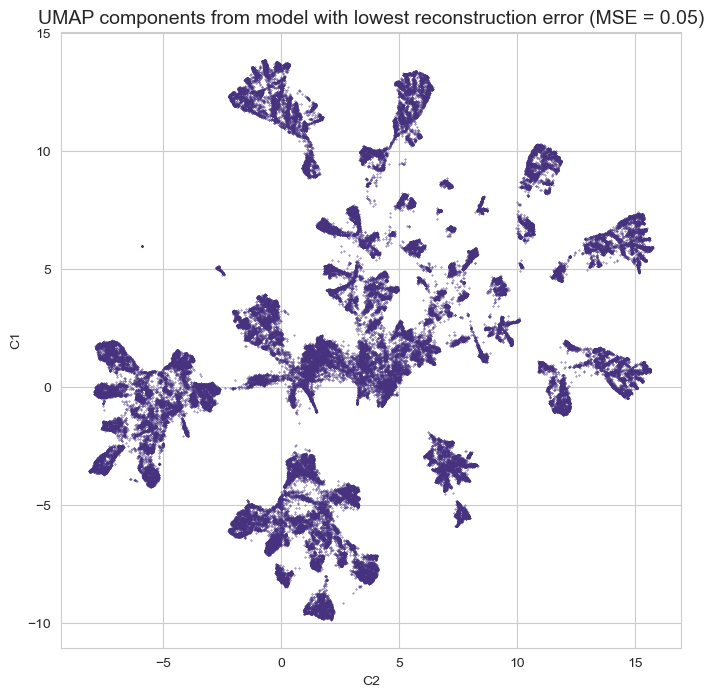

In [270]:
# Plotting Embedded data
plt.figure(figsize = [8,8]) 
plt.scatter(tuned_umap_df["C2"], tuned_umap_df["C1"], s = 0.1)
plt.ylabel('C1')
plt.xlabel('C2')
plt.title(f'UMAP components from model with lowest reconstruction error (MSE = {round(umap_assessment["reconstruction_error"].min(), 2)})', 
          fontsize = 14)

In [35]:
# Preparing splits
tuned_umap_splits = list(kfolds.split(tuned_umap_df))

In [271]:
# Scoring function required for gridsearch
def silhouette_scorer(model, X):
    labels = model.fit_predict(X)
    if len(set(labels)) > 1:  
        return silhouette_score(X, labels)
    else:
        return -1  # Return a low score for a single cluster or noise

# Custom function to compile each fold's labels to assess stability
def stability_scorer(model, X, fold_pairs, fold_labels):
    labels = model.fit_predict(X)
    fold_labels.append(labels)
    fold_pairs.append(dict(zip(X.index, labels)))
    return 1

In [272]:
## HDBSCAN
# Building model 
hdbscan_model = HDBSCAN(algorithm = 'auto', 
                        metric = 'euclidean') 
                        # store_centers = 'centroid' isn't useful as the space is predefined, the densities may vary

# Preparing hyperparameters to search over
hdbscan_grid_params = {'min_cluster_size': [85], #[84, 85, 86],     # Clusters smaller than this will be marked as noise 
                       'min_samples' : [8] #[6, 7, 8, 9]            # Initial core point size
                       }   
# Preparing containers to assess stability accross the five folds
fold_labels = []
fold_pairs = []

# Gridsearch pipeline
hdbscan_gs = GridSearchCV(hdbscan_model, 
                         hdbscan_grid_params, 
                         cv = tuned_umap_splits,
                         scoring = {'silhouette': silhouette_scorer, 'ARI': lambda model, X: stability_scorer(model, X,fold_pairs, fold_labels)}, 
                         refit = 'silhouette',
                         return_train_score =  True)
    
# Fitting model
hdbscan_gs.fit(tuned_umap_df)

# Viewing gridsearch findings
hdbscan_gs_results = hdbscan_gs.cv_results_
tuned_hdbscan = hdbscan_gs.best_estimator_
print(f"The best model: {tuned_hdbscan}")
best_score = hdbscan_gs.best_score_
print(f"The best score: {best_score}")

# Measuring silhouette scores
start_time = time.time()
tuned_hdbscan_labels = tuned_hdbscan.fit_predict(tuned_umap_df)
end_time = time.time()

# Viewing output
print(f'This model took {end_time - start_time} to process the UMAP dataset') 
pd.DataFrame(hdbscan_gs_results)

The best model: HDBSCAN(min_cluster_size=85, min_samples=8)
The best score: 0.4424177348613739
This model took 70.63817930221558 to process the UMAP dataset


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      46.498124      2.417953        13.353466          1.1959   

   param_min_cluster_size  param_min_samples  \
0                      85                  8   

                                       params  split0_test_silhouette  \
0  {'min_cluster_size': 85, 'min_samples': 8}                0.432568   

   split1_test_silhouette  split2_test_silhouette  split3_test_silhouette  \
0                0.452259                0.422873                0.465168   

   split4_test_silhouette  mean_test_silhouette  std_test_silhouette  \
0                 0.43922              0.442418             0.014857   

   rank_test_silhouette  split0_train_silhouette  split1_train_silhouette  \
0                     1                 0.324407                 0.336726   

   split2_train_silhouette  split3_train_silhouette  split4_train_silhouette  \
0                 0.328993                 0.341406                 0.332911   

   mean_train_silhouette  std_train_silhouette  split0_test_ARI  \
0               0.332889              0.005905              1.0   

   split1_test_ARI  split2_test_ARI  split3_test_ARI  split4_test_ARI  \
0              1.0              1.0              1.0              1.0   

   mean_test_ARI  std_test_ARI  rank_test_ARI  split0_train_ARI  \
0            1.0           0.0              1               1.0   

   split1_train_ARI  split2_train_ARI  split3_train_ARI  split4_train_ARI  \
0               1.0               1.0               1.0               1.0   

   mean_train_ARI  std_train_ARI  
0             1.0            0.0

In [284]:
## Assessment of stability
# Creating containers
train_unique_labels = []
test_unique_labels = []

# Getting labels identified per fold
test_train = 2
for fold in fold_labels:
    if test_train % 2 == 0:
        label, count = np.unique(fold, return_counts = True)
        train_unique_labels.append(len(count))
    else:
        label, count = np.unique(fold, return_counts = True)
        test_unique_labels.append(len(count))
    test_train += 1

# Printing findings
print(f'The count from each fold of the training sets: {train_unique_labels}, this represents a standard deviation of \
{round(np.std(train_unique_labels),3)}')

print(f'The count from each fold of the testing sets: {test_unique_labels}, this represents a standard deviation of \
{round(np.std(test_unique_labels),3)}')
#### NOTE - Density varies with fewer points, but the behavior is fine.

The count from each fold of the training sets: [67, 66, 64, 67, 65], this represents a standard deviation of 1.166
The count from each fold of the testing sets: [235, 228, 232, 237, 218], this represents a standard deviation of 6.723


In [285]:
# Saving output from HDBSCAN
filename = datetime.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")
file = "C:\\Users\\Dylan Rohan\\OneDrive - University of Adelaide\\data_science_research_project\\project_files\\output_files\\" + \
        f"umap_hdbscan_{filename}.csv"
pd.DataFrame(hdbscan_gs_results).to_csv(file)

In [286]:
# Obtaining the number of clusters with representation of at least x instances
val_count = pd.DataFrame(pd.DataFrame(tuned_hdbscan_labels).value_counts(), columns= ["count"])
print(f"There are {val_count.at[(-1,), 'count']} noise points, which corresponds to \
{round((val_count.at[(-1,), 'count'])*100/len(tuned_hdbscan_labels), 2)}% of the data")
print(f"There are/is {len(val_count[val_count['count'] > 500])} clusters with atleast 500 memebers")
print(f"There are/is {len(val_count[val_count['count'] > 1000])} clusters with atleast 1000 memebers")
print(f"There are/is {len(val_count[val_count['count'] > 2000])} clusters with atleast 2000 memebers")

There are 15233 noise points, which corresponds to 15.31% of the data
There are/is 40 clusters with atleast 500 memebers
There are/is 9 clusters with atleast 1000 memebers
There are/is 1 clusters with atleast 2000 memebers


The final model found 281 different clusters


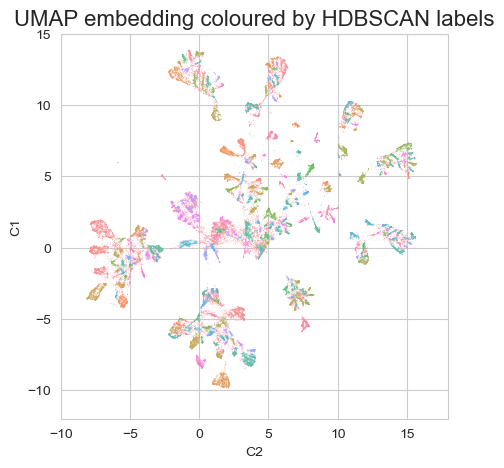

In [287]:
# Finding the number of clusters in the final model
cluster_count = len(pd.DataFrame(tuned_hdbscan_labels).value_counts())
print(f"The final model found {cluster_count} different clusters")

# Assigning these clusters to their associated instances  
final_output = tuned_umap_df.copy()
final_output['label'] = tuned_hdbscan_labels
final_output['label'] = final_output['label'].astype(str)

# Plotting UMAP embedded data whith colour label
Final_cluster_img = plt.figure(figsize = (5,5)) 
sns.scatterplot(data = final_output, x= "C2", y = "C1", hue = 'label', s = 0.1)
plt.ylabel('C1')
plt.xlabel('C2')
plt.xlim([-10, 18])
plt.ylim([-12, 15])
plt.legend('',frameon=False)
plt.title(f'UMAP embedding coloured by HDBSCAN labels', size = 16)
plt.show()

Choose a label 12


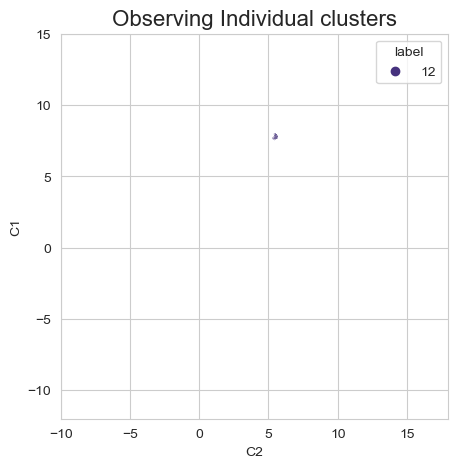

In [291]:
# Visual seperation check to demonstrate the effectiveness of HDBSCAN
cluster_check = final_output[final_output['label'] == input(f'Choose a label')]
cluster_check_img = plt.figure(figsize = (5,5)) 
sns.scatterplot(data = cluster_check, x= "C2", y = "C1", hue = 'label', s = 0.1)
plt.ylabel('C1')
plt.xlabel('C2')
plt.xlim([-10, 18])
plt.ylim([-12, 15])
plt.title(f'Observing Individual clusters', size = 16)
plt.show()

#### Trial on alternate HDBSCAN module with more functionality
The scikit module is excellent for hyperparameter tuning, but it doesn't provide all the tools available. 
While there will be small diferences between the two outputs, the optimal hyperparameters are expected to be similar. 
For the sake of investigation and more meaningful verification, we have introduced a secondary HDBSCAN model below: 

In [123]:
# Building model on known hyperparameters
secondary_hdbscan = HDBSCAN_2.HDBSCAN(min_cluster_size = 85, min_samples = 8)

# Fitting model
sec_HDBSCAN_labels = secondary_hdbscan.fit_predict(tuned_umap_df)

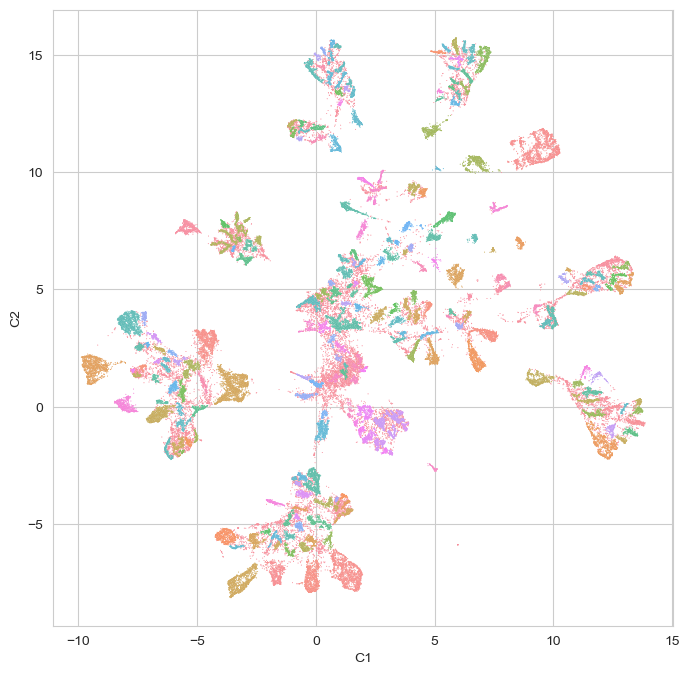

In [225]:
# Compiling into dataframe
sec_output = tuned_umap_df.copy()
sec_output['label'] = sec_HDBSCAN_labels
sec_output['label'] = sec_output['label'].astype(str)

# Scatter plot
plt.figure(figsize = (8, 8))
sns.scatterplot(data = sec_output, x= 'C1', y ='C2', hue = 'label', s = 0.5)
plt.legend('', frameon=False)

The dendrograms can be used to assist in the selection of granularity, though the model isn't necessarily designed specifically for that purpose.


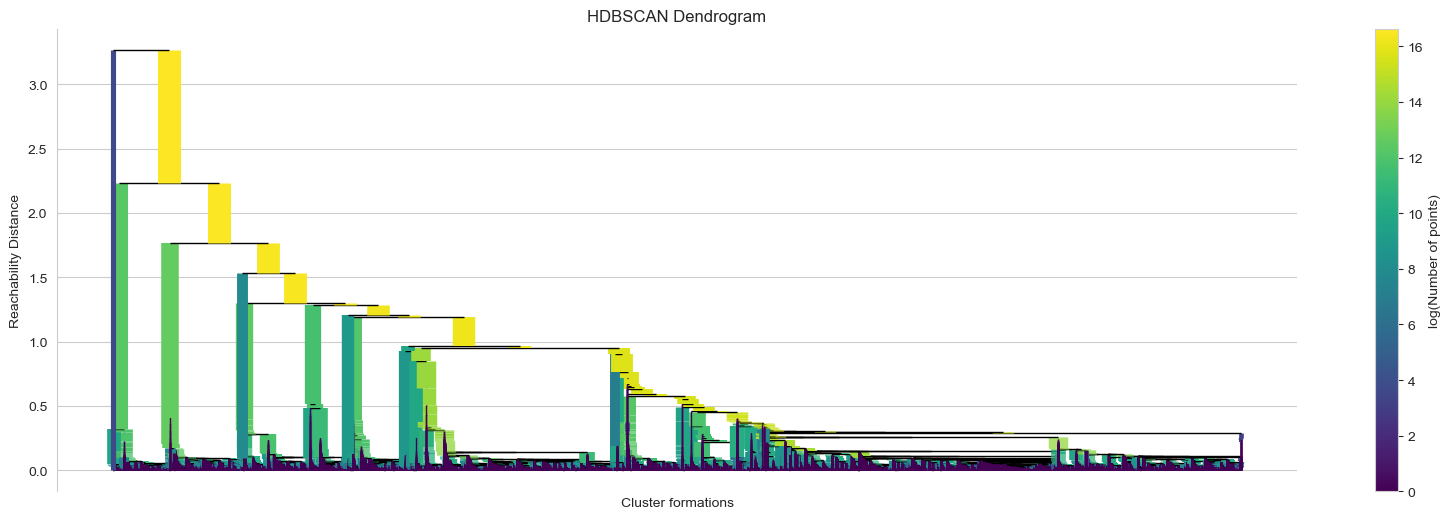

In [227]:
# Obtianing data to plot dendrogram
linkage_tree = secondary_hdbscan.single_linkage_tree_

# Plot the dendrogram
print("The dendrograms can be used to assist in the selection of granularity, though the model isn't necessarily designed \
specifically for that purpose.")
plt.figure(figsize=(20, 6))
linkage_tree.plot()
plt.title('HDBSCAN Dendrogram')
plt.xlabel('Cluster formations')
plt.ylabel('Reachability Distance')
plt.show()

Below I test the difference of euclidean and mutual reachability distances when calculating the silhouette score given that UMAP uses mutual reachability distance. However, visualizations indicate that the mutual reachability metric is not that meaningful as clusters were observable prior to the HDBSCAN model meaning UMAP is the component that most needs verification. Though there are few ways this can be done with unlabelled data (really only the reverse transformation and measurement of eror).

In [126]:
# Obtain reachability distances
reachability_distances = secondary_hdbscan.single_linkage_tree_.to_numpy()[:, 2]

# Get cluster labels and remove noise
labels = tuned_hdbscan_labels
valid_points = labels != -1  
valid_indices = np.where(valid_points)[0]

# Prepare arrays
a_distances = np.zeros(len(valid_indices))
b_distances = np.zeros(len(valid_indices))

# Unique cluster labels, ignoring noise (-1)
unique_labels = np.unique(labels[valid_points])

# Compute intra-cluster distances (a_distances)
for label in unique_labels:
    cluster_indices = valid_indices[labels[valid_points] == label]
    reachability_intra_cluster = reachability_distances[cluster_indices]
    a_distances[labels[valid_points] == label] = np.mean(reachability_intra_cluster)

# Compute inter-cluster distances (b_distances) for each valid point
for label in unique_labels:
    cluster_indices = valid_indices[labels[valid_points] == label]
    inter_cluster_distances = np.full(len(cluster_indices), np.inf)

    for other_label in unique_labels:
        if other_label == label:
            continue

        # Get distances to points in other clusters
        other_cluster_indices = valid_indices[labels[valid_points] == other_label]
        
        # Calculate reachability distances to other clusters for each point in current cluster
        for i, idx in enumerate(cluster_indices):
            inter_distances = reachability_distances[other_cluster_indices]
            inter_cluster_distances[i] = min(inter_cluster_distances[i], np.mean(inter_distances))

    b_distances[labels[valid_points] == label] = inter_cluster_distances

# Calculate silhouette scores
silhouette_scores = (b_distances - a_distances) / np.maximum(a_distances, b_distances)

# Mean silhouette score
mean_sil_score_reachability_metric = np.nanmean(silhouette_scores)
print(f'Mean silhouette score (using reachability distance metric): {mean_sil_score_reachability_metric}')
print(f'Mean silhouette score (using euclidean distance metric): {silhouette_score(tuned_umap_df, sec_HDBSCAN_labels)}')

Mean silhouette score (using reachability distance metric): -0.6617539046721875
Mean silhouette score (using euclidean distance metric): 0.33957138657569885


### Analysis of Results from UMAP+HDBSCAN model (from the primary results achieved with the scikit-learn package)

In [292]:
# Preparing results dataframe
identity_features = high_instances_df.iloc[:, :3]
results_df = identity_features.join(final_output)
results_df_noiseless = results_df[results_df['label']  != '-1']
results_df_noiseless

race  gender      age         C1        C2 label
0            Caucasian  Female   [0-10)  -5.533030  7.959600     0
1            Caucasian  Female  [10-20)  12.470757  6.300847   121
3            Caucasian    Male  [30-40)  12.283931 -0.073393   158
4            Caucasian    Male  [40-50)  13.795531 -0.796851    70
5            Caucasian    Male  [50-60)  -1.903242 -6.626352    47
...                ...     ...      ...        ...       ...   ...
99487  AfricanAmerican  Female  [60-70)   0.873537  2.109731   271
99488  AfricanAmerican    Male  [70-80)   7.624258  3.006589    40
99489  AfricanAmerican  Female  [80-90)   6.590817  7.335567     4
99490        Caucasian    Male  [70-80)  11.307617  1.705047    87
99491        Caucasian  Female  [80-90)  -0.134411 -3.481612   175

[84260 rows x 6 columns]

#### Results - Race

In [293]:
# Assessing population statistics for each cluster
race_count = results_df_noiseless.groupby(['label', 'race']).size().reset_index(name='race_count')

# Putting a number to overall representation
race_representation = race_count.groupby('race')['race_count'].sum().reset_index()
race_representation['% representation'] = round(100*(race_representation['race_count'])/race_representation['race_count'].sum(), 2)
race_representation

race  race_count  % representation
0  AfricanAmerican       16306             19.35
1            Asian         556              0.66
2        Caucasian       64370             76.39
3         Hispanic        1741              2.07
4            Other        1287              1.53

There doesn't appear to be any large structures with poor representation.


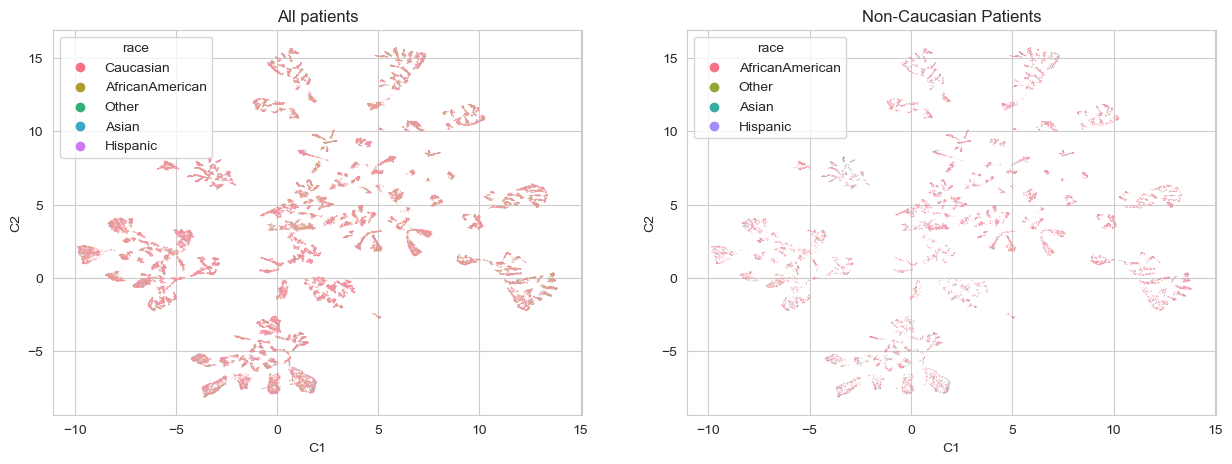

In [294]:
# Scatter plot to identify race in the umap embedding
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.scatterplot(data = results_df_noiseless, x= 'C1', y ='C2', hue = 'race', s = 0.2, palette = 'husl')
plt.title( "All patients")

plt.subplot(1,2,2)
sns.scatterplot(data = results_df_noiseless[results_df_noiseless['race'] != 'Caucasian'], x= 'C1', y ='C2', hue = 'race', s = 0.2, palette = 'husl')
plt.title("Non-Caucasian Patients") 

# Assessment
print("There doesn't appear to be any large structures with poor representation.")

In [295]:
# Aggregating race by label
race_count['total_per_label'] = race_count.groupby('label')['race_count'].transform('sum')
race_count['% representation'] = round(100*(race_count['race_count'])/race_count['total_per_label'],3)
race_count

label             race  race_count  total_per_label  % representation
0        0  AfricanAmerican         174              919            18.934
1        0            Asian           5              919             0.544
2        0        Caucasian         723              919            78.672
3        0         Hispanic           5              919             0.544
4        0            Other          12              919             1.306
...    ...              ...         ...              ...               ...
1242    98            Other           2              129             1.550
1243    99  AfricanAmerican          51              182            28.022
1244    99        Caucasian         120              182            65.934
1245    99         Hispanic           5              182             2.747
1246    99            Other           6              182             3.297

[1247 rows x 5 columns]

In [296]:
# Creating pivot table to observe each clusters representation
wide_race = race_count.pivot_table(index = 'label', columns = 'race', values = '% representation', aggfunc = 'sum', fill_value = 0)

# Finding clusters with low caucasian representation
wide_race.sort_values(['AfricanAmerican'], ascending = False)

race   AfricanAmerican  Asian  Caucasian  Hispanic  Other
label                                                    
27              42.814  0.599     51.198     4.790  0.599
24              42.697  0.000     49.438     7.865  0.000
70              40.115  0.287     55.301     2.865  1.433
89              39.631  1.382     52.995     3.687  2.304
54              39.548  0.000     50.282     7.910  2.260
...                ...    ...        ...       ...    ...
249              5.670  0.000     93.299     0.000  1.031
188              5.625  1.250     90.625     1.250  1.250
253              5.607  0.000     91.589     0.935  1.869
252              5.442  0.170     92.517     1.361  0.510
168              4.065  2.439     88.618     3.252  1.626

[280 rows x 5 columns]

It appears some clusters do stray from the population statistcs considerably, below we assess the statistical significance.

In [297]:
# Finding clusters with high caucasian representation
wide_race.sort_values(['Caucasian'], ascending = False)

race   AfricanAmerican  Asian  Caucasian  Hispanic  Other
label                                                    
249              5.670  0.000     93.299     0.000  1.031
272              5.991  0.461     92.627     0.922  0.000
252              5.442  0.170     92.517     1.361  0.510
253              5.607  0.000     91.589     0.935  1.869
236              7.463  0.746     91.045     0.000  0.746
...                ...    ...        ...       ...    ...
88              39.462  1.345     52.018     5.381  1.794
59              39.241  1.899     51.266     4.430  3.165
27              42.814  0.599     51.198     4.790  0.599
54              39.548  0.000     50.282     7.910  2.260
24              42.697  0.000     49.438     7.865  0.000

[280 rows x 5 columns]

There are also groups here with considerably high proportions of Caucasian patients. 

Below, I grouped the patients into caucasian and non-caucasian to ensure that there was enough representation in each category to ensure the chi-squared test holds validity (enough representation within each group). The above implies there is an association between cluster label and ethnicty (for the non-noise instances). The p-value is well below 0.05 meaning there is little chance that this is the result of random chance. However the assoication is weak to moderate given the Cramér’s V value. This is likely the result of the time and geographical distance ranges. 

In [298]:
# Statistical relevance of caucasian/non-caucasian balance in clusters
results_df_noiseless_copy = results_df_noiseless.copy()
results_df_noiseless_copy['race'] = results_df_noiseless_copy['race'].replace({'AfricanAmerican': 'Non-Caucasian', 
                                                                               'Asian': 'Non-Caucasian',
                                                                               'Hispanic': 'Non-Caucasian',
                                                                               'Other': 'Non-Caucasian'})

# Contingency table 
contingency_table_race = pd.crosstab(results_df_noiseless_copy['label'], results_df_noiseless_copy['race'])

# Chi-squareed test of independence
chi2_race, p_race, dof_race, expected_race = chi2_contingency(contingency_table_race)


expected_df_race = pd.DataFrame(expected_race, index = contingency_table_race.index, columns = contingency_table_race.columns)
low_counts = (expected_df_race < 5).sum().sum()

if low_counts > 0.2 * expected_df_race.size:
    print("Warning: More than 20% of cells have expected counts below 5.")

# Cramer's V (measuring association)
## Summing frequencies
n_race = contingency_table_race.values.sum()
## Getting minimum dimensions
min_dim_race = min(contingency_table_race.shape) - 1
cramers_v_race = np.sqrt(chi2_race / (n_race * min_dim_race))

# Printing results
print(f"Chi2 Statistic: {round(chi2_race, 2)}, P-value: {p_race} (dof = {dof_race})")
print(f"Cramér’s V: {cramers_v_race}")

Chi2 Statistic: 2915.44, P-value: 0.0 (dof = 279)
Cramér’s V: 0.18601228852676066


In [299]:
# Creating pivot table with race counts alongside a cluster member count
race_count = results_df_noiseless.groupby(['label', 'race']).size().reset_index(name='race_count')
race_count = race_count.pivot_table(index = 'label', 
                                    columns = 'race', 
                                    values = 'race_count', 
                                    aggfunc = 'sum', 
                                    fill_value = 0, 
                                    margins = True)
race_count = race_count.drop('All')

# Extending to include proportions of each ethnicity
race_count['% AfricanAmerican'] = race_count['AfricanAmerican']/race_count['All']
race_count['% Asian'] = race_count['Asian']/race_count['All']
race_count['% Caucasian'] = race_count['Caucasian']/race_count['All']
race_count['% Hispanic'] = race_count['Hispanic']/race_count['All']
race_count['% Other']	= race_count['Other']/race_count['All']

# Checking assumptions
race_count['sample_size_valid'] = ((race_count['All'] * race_count['% AfricanAmerican'] >= 10) & 
                                   (race_count['All'] * (1 - race_count['% AfricanAmerican']) >= 10))

# Looking at groups where assumption holds true
race_count = race_count[race_count['sample_size_valid']==True]

race_count

race   AfricanAmerican  Asian  Caucasian  Hispanic  Other   All  \
label                                                             
0                  174      5        723         5     12   919   
1                   49      0        176         1      5   231   
10                 278     14       1246        33     21  1592   
100                 31      1         51         3      0    86   
101                 43      1         97         4      1   146   
...                ...    ...        ...       ...    ...   ...   
95                  55      4        201         3      7   270   
96                  61      3        165         3      4   236   
97                 113      1        334        10      4   462   
98                  37      0         85         5      2   129   
99                  51      0        120         5      6   182   

race   % AfricanAmerican   % Asian  % Caucasian  % Hispanic   % Other  \
label                                                                   
0               0.189336  0.005441     0.786725    0.005441  0.013058   
1               0.212121  0.000000     0.761905    0.004329  0.021645   
10              0.174623  0.008794     0.782663    0.020729  0.013191   
100             0.360465  0.011628     0.593023    0.034884  0.000000   
101             0.294521  0.006849     0.664384    0.027397  0.006849   
...                  ...       ...          ...         ...       ...   
95              0.203704  0.014815     0.744444    0.011111  0.025926   
96              0.258475  0.012712     0.699153    0.012712  0.016949   
97              0.244589  0.002165     0.722944    0.021645  0.008658   
98              0.286822  0.000000     0.658915    0.038760  0.015504   
99              0.280220  0.000000     0.659341    0.027473  0.032967   

race   sample_size_valid  
label                     
0                   True  
1                   True  
10                  True  
100                 True  
101                 True  
...                  ...  
95                  True  
96                  True  
97                  True  
98                  True  
99                  True  

[274 rows x 12 columns]

In [300]:
# Defining function to calculate Z-statistic for each cluster
def z_stat(df, row, subgroup):
    # Getting proportions
    row = str(row)
    observed_proportion  = df.loc[row, '% ' + subgroup]
    population_proportion = df[subgroup].sum() / df['All'].sum()

    # Calcultaing Z-stat
    z_stat_value_numerator = (observed_proportion-population_proportion)
    z_stat_value_denominator = np.sqrt((population_proportion * (1 - population_proportion)) / df.loc[row, 'All'].sum())
    z_stat_value = z_stat_value_numerator/z_stat_value_denominator
    
    # Calculating p_value
    z_stat_p_value = 2 * (1 - norm.cdf(abs(z_stat_value)))
    
    return z_stat_value, z_stat_p_value

# Test
z_stat(race_count, 0, 'AfricanAmerican')

(-0.40311793824257885, 0.6868614648545)

In [301]:
# Preparing containers to hold z-scores and p-values 
z_stats_Afr_Ameri = []
p_value_Afr_Ameri = []

# Looping through each cluster
indexation = race_count.index.to_list()
for element in indexation:
    z_stats, p_value  = z_stat(race_count, element, 'AfricanAmerican')
    z_stats_Afr_Ameri.append(z_stats)
    p_value_Afr_Ameri.append(p_value)

# Adding these values to the list
race_count['AfricanAmerican z-score'] = z_stats_Afr_Ameri
race_count['AfricanAmerican p-value'] = p_value_Afr_Ameri

In [302]:
# Observing clusters with p-values of <0.05
significant_AfriAmeri = race_count[race_count['AfricanAmerican p-value'] <= 0.05]
num_signif_clusters = len(significant_AfriAmeri)
odd_z_stat = len(significant_AfriAmeri[(significant_AfriAmeri['AfricanAmerican z-score']>3) | (significant_AfriAmeri['AfricanAmerican z-score']<-3)])
print(f'There are {num_signif_clusters} clusters demonstrating significance (p-value < 0.05). Of these, {odd_z_stat} \
had a z-stat score that indicated African Americans in the clusters are more than three standard deviations away from the expected \
proportion.')

There are 142 clusters demonstrating significance (p-value < 0.05). Of these, 91 had a z-stat score that indicated African Americans in the clusters are more than three standard deviations away from the expected proportion.


In [303]:
## Repeating for Caucassian
# Preparing containers to hold z-scores and p-values 
z_stats_cau = []
p_value_cau = []

# Looping through each cluster
indexation = race_count.index.to_list()
for element in indexation:
    # z_stats_Afr_Ameri.append
    z_stats, p_value  = z_stat(race_count, element, 'Caucasian')
    z_stats_cau.append(z_stats)
    p_value_cau.append(p_value)

# Adding these values to the dataframe
race_count['Caucasian z-score'] = z_stats_Afr_Ameri
race_count['Caucasian p-value'] = p_value_Afr_Ameri

In [304]:
# Observing clusters with p-values of <0.05
significant_cau = race_count[race_count['Caucasian p-value'] <= 0.05]
num_signif_clusters = len(significant_cau)
odd_z_stat = len(significant_cau[(significant_cau['Caucasian z-score']>3) | (significant_cau['Caucasian z-score']<-3)])
print(f'There are {num_signif_clusters} clusters demonstrating significance (p-value < 0.05). Of these, {odd_z_stat} \
had a z-stat score that indicated African Americans in the clusters are more than three standard deviations away from the expected \
proportion.')

There are 142 clusters demonstrating significance (p-value < 0.05). Of these, 91 had a z-stat score that indicated African Americans in the clusters are more than three standard deviations away from the expected proportion.


In [305]:
# Checking cluster sizes
signif_cluster_indices = significant_AfriAmeri[(significant_AfriAmeri['AfricanAmerican z-score']>3) | \
                                        (significant_AfriAmeri['AfricanAmerican z-score']<-3)].index.to_list()
signif_clusters = race_count.loc[signif_cluster_indices].sort_values('% Caucasian', ascending = False)
print(f'You can see below that these clusters include between {round((86/84260)*100, 3)}% and {round(1672/84260*100,3)}% \
of the non-noise instances: \n')  
signif_clusters

You can see below that these clusters include between 0.102% and 1.984% of the non-noise instances: 



race   AfricanAmerican  Asian  Caucasian  Hispanic  Other  All  \
label                                                            
249                 11      0        181         0      2  194   
272                 13      1        201         2      0  217   
252                 32      1        544         8      3  588   
236                 10      1        122         0      1  134   
197                 29      2        352         1      8  392   
...                ...    ...        ...       ...    ...  ...   
88                  88      3        116        12      4  223   
59                  62      3         81         7      5  158   
27                 143      2        171        16      2  334   
54                  70      0         89        14      4  177   
24                  38      0         44         7      0   89   

race   % AfricanAmerican   % Asian  % Caucasian  % Hispanic   % Other  \
label                                                                   
249             0.056701  0.000000     0.932990    0.000000  0.010309   
272             0.059908  0.004608     0.926267    0.009217  0.000000   
252             0.054422  0.001701     0.925170    0.013605  0.005102   
236             0.074627  0.007463     0.910448    0.000000  0.007463   
197             0.073980  0.005102     0.897959    0.002551  0.020408   
...                  ...       ...          ...         ...       ...   
88              0.394619  0.013453     0.520179    0.053812  0.017937   
59              0.392405  0.018987     0.512658    0.044304  0.031646   
27              0.428144  0.005988     0.511976    0.047904  0.005988   
54              0.395480  0.000000     0.502825    0.079096  0.022599   
24              0.426966  0.000000     0.494382    0.078652  0.000000   

race   sample_size_valid  AfricanAmerican z-score  AfricanAmerican p-value  \
label                                                                        
249                 True                -4.851614             1.224610e-06   
272                 True                -5.011833             5.391403e-07   
252                 True                -8.586052             0.000000e+00   
236                 True                -3.508012             4.514690e-04   
197                 True                -6.032377             1.615656e-09   
...                  ...                      ...                      ...   
88                  True                 7.544736             4.529710e-14   
59                  True                 6.280391             3.377232e-10   
27                  True                10.781082             0.000000e+00   
54                  True                 6.750634             1.472000e-11   
24                  True                 5.537185             3.073711e-08   

race   Caucasian z-score  Caucasian p-value  
label                                        
249            -4.851614       1.224610e-06  
272            -5.011833       5.391403e-07  
252            -8.586052       0.000000e+00  
236            -3.508012       4.514690e-04  
197            -6.032377       1.615656e-09  
...                  ...                ...  
88              7.544736       4.529710e-14  
59              6.280391       3.377232e-10  
27             10.781082       0.000000e+00  
54              6.750634       1.472000e-11  
24              5.537185       3.073711e-08  

[91 rows x 16 columns]

C:\Users\Dylan Rohan\AppData\Local\Temp\ipykernel_7668\2506849085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_race.sort_values('% AfricanAmerican', inplace = True)


Text(0, 0.5, 'Proportion')

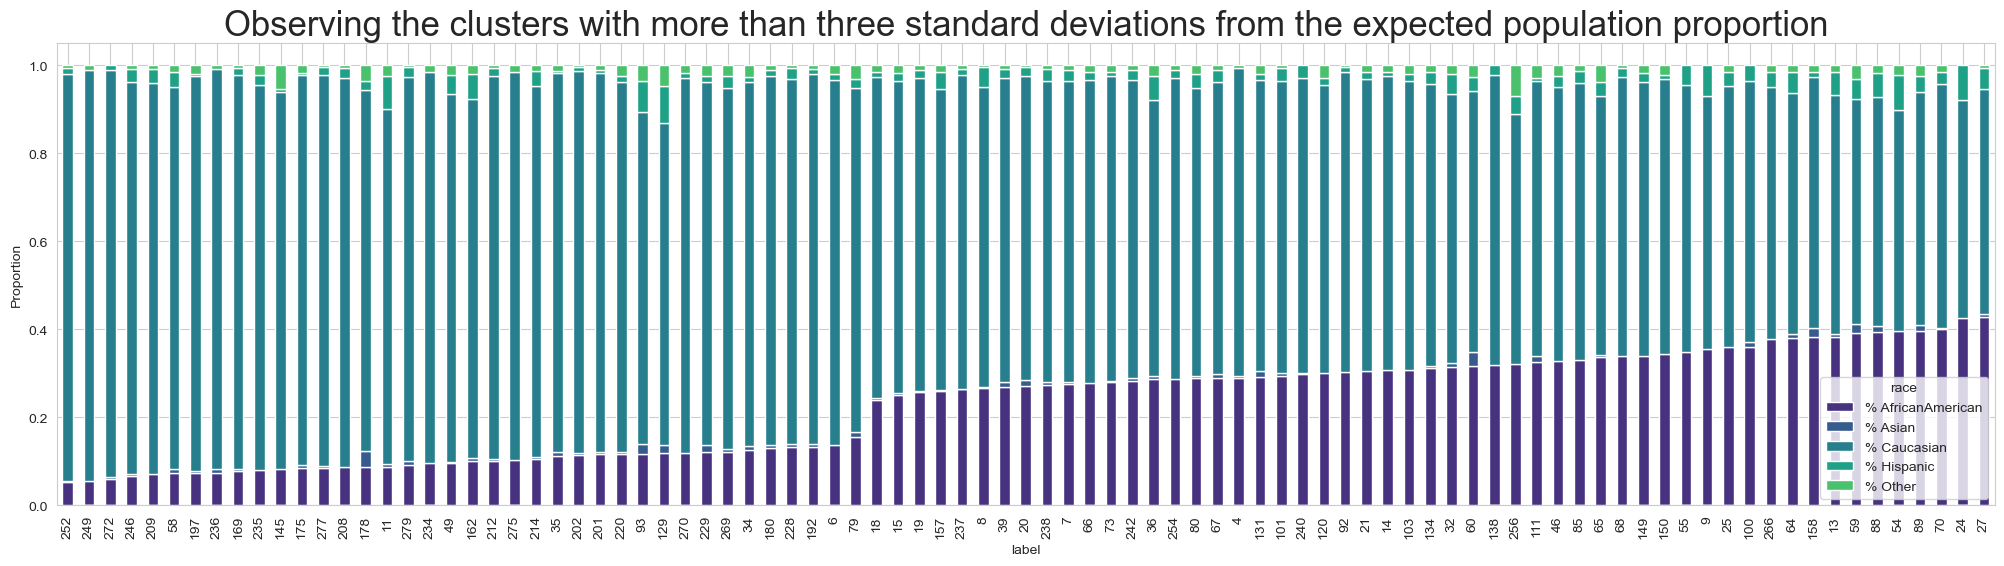

In [306]:
# Obtianing ethnicity proportions for each cluster
plot_race = signif_clusters[['% AfricanAmerican','% Asian',	'% Caucasian',	'% Hispanic',	'% Other']]
plot_race.sort_values('% AfricanAmerican', inplace = True)

# Plotting a stacked bar chart
plot_race.plot(kind = 'bar', stacked = True, figsize = (25, 6))
plt.title('Observing the clusters with more than three standard deviations from the expected population proportion', fontsize = 25 )
plt.ylabel('Proportion')

#### Results - Gender

In [307]:
# Assessing population statistics for each cluster
gender_count = results_df_noiseless.groupby(['label', 'gender']).size().reset_index(name='gender_count')

# Putting a number to overall representation
gender_representation = gender_count.groupby('gender')['gender_count'].sum().reset_index()
gender_representation['% representation'] = round(100*(gender_representation['gender_count'])/gender_representation['gender_count'].sum(), 3)
gender_representation

gender  gender_count  % representation
0           Female         45394            53.874
1             Male         38865            46.125
2  Unknown/Invalid             1             0.001

No obvious seperation or dominance observed


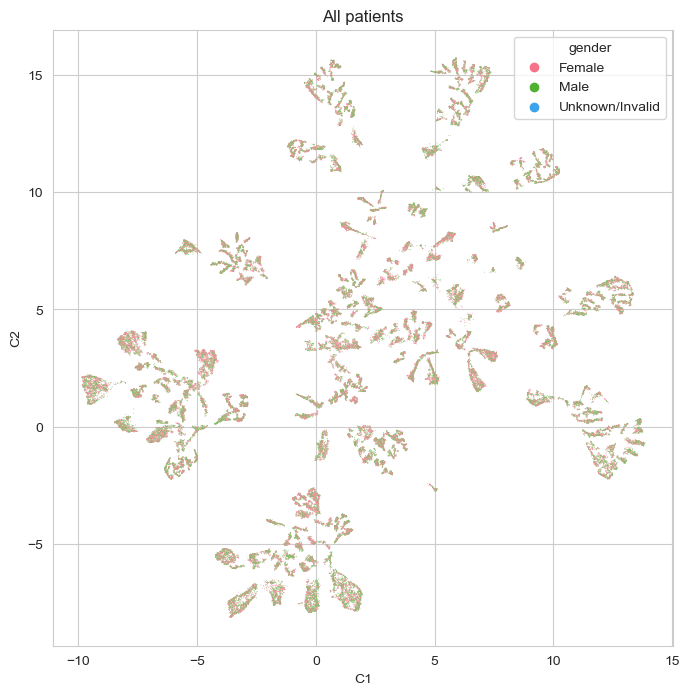

In [308]:
# Scatter plot to identify gender in the umap embedding
plt.figure(figsize = (8, 8))
sns.scatterplot(data = results_df_noiseless, x= 'C1', y ='C2', hue = 'gender', s = 0.3, palette = 'husl')
plt.title("All patients")
print('No obvious seperation or dominance observed')

In [309]:
# Aggregating gender by label
gender_count['total_per_label'] = gender_count.groupby('label')['gender_count'].transform('sum')
gender_count['% representation'] = round(100*(gender_count['gender_count'])/gender_count['total_per_label'],3)
gender_count

label  gender  gender_count  total_per_label  % representation
0       0  Female           485              919            52.775
1       0    Male           434              919            47.225
2       1  Female           129              231            55.844
3       1    Male           102              231            44.156
4      10  Female           808             1592            50.754
..    ...     ...           ...              ...               ...
556    97    Male           214              462            46.320
557    98  Female            66              129            51.163
558    98    Male            63              129            48.837
559    99  Female           101              182            55.495
560    99    Male            81              182            44.505

[561 rows x 5 columns]

In [310]:
# Giving each cluster its own row
wide_gender = gender_count.pivot_table(index = 'label', columns = 'gender', values = '% representation', aggfunc = 'sum', fill_value = 0)

# Finding clusters with low female representation
wide_gender.sort_values(['Female'], ascending = False, inplace = True)
wide_gender.drop('Unknown/Invalid', axis = 1, inplace = True)
wide_gender

gender  Female    Male
label                 
188     73.750  26.250
239     72.917  27.083
74      68.636  31.364
172     68.571  31.429
165     66.848  33.152
...        ...     ...
178     37.450  62.550
185     37.037  62.963
145     35.606  64.394
222     35.018  64.982
105     32.979  67.021

[280 rows x 2 columns]

NOTE - I have dropped the single remaining instance of 'Unknown/Invalid'. I apologise for the erasure but I simply dont have the data to provide meaningful insights on this group. There may be systemic issues at play preventing this group from being represented.

In [311]:
## Statistical relevance of gender balance in clusters
results_df_noiseless_copy = results_df_noiseless.copy()

# Contingency table 
contingency_table_gender = pd.crosstab(results_df_noiseless_copy['label'], results_df_noiseless_copy['gender'])
contingency_table_gender.drop('Unknown/Invalid', axis = 1, inplace = True)

# Chi-squareed test of independence
chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_table_gender)

expected_df_gender = pd.DataFrame(expected_gender, index = contingency_table_gender.index, columns = contingency_table_gender.columns)
low_counts = (expected_df_gender < 5).sum().sum()

if low_counts > 0.2 * expected_df_gender.size:
    print("Warning: More than 20% of cells have expected counts below 5.")

## Cramer's V (measuring association)
# Summing frequencies
n_gender = contingency_table_gender.values.sum()
# Getting minimum dimensions
min_dim_gender = min(contingency_table_gender.shape) - 1
cramers_v_gender = np.sqrt(chi2_gender / (n_gender * min_dim_gender))

# Printing results
print(f"Chi2 Statistic: {round(chi2_gender, 2)}, P-value: {round(p_gender, 2)} (dof = {round(dof_gender,2)})")
print(f"Cramér’s V: {round(cramers_v_gender, 5)}")

Chi2 Statistic: 1386.43, P-value: 0.0 (dof = 279)
Cramér’s V: 0.12827


Similar findings for this identity feature - p-values lower than 0.05 indicating significance, and cramer's V indicating a weak to moderate association between clusters and gender.

In [312]:
# Creating pivot table with gender counts alongside a cluster member count
gender_count = results_df_noiseless.groupby(['label', 'gender']).size().reset_index(name='gender_count')
gender_count = gender_count.pivot_table(index = 'label', 
                                     columns = 'gender', 
                                     values = 'gender_count', 
                                     aggfunc = 'sum', 
                                     fill_value = 0, 
                                     margins = True)

gender_count.drop('Unknown/Invalid', axis = 1, inplace = True)
gender_count.drop('All', axis = 0, inplace = True)

# Extending to include proportions of each ethnicity
gender_count['% Male'] = gender_count['Male']/gender_count['All']
gender_count['% Female'] = gender_count['Female']/gender_count['All']

# Checking assumptions
gender_count['sample_size_valid'] = ((gender_count['All'] * gender_count['% Female'] >= 10) & 
                                   (gender_count['All'] * (1 - gender_count['% Female']) >= 10))

# Looking at groups where assumption holds true
gender_count = gender_count[gender_count['sample_size_valid']==True]

gender_count

gender  Female  Male   All    % Male  % Female  sample_size_valid
label                                                            
0          485   434   919  0.472252  0.527748               True
1          129   102   231  0.441558  0.558442               True
10         808   784  1592  0.492462  0.507538               True
100         45    41    86  0.476744  0.523256               True
101         79    67   146  0.458904  0.541096               True
...        ...   ...   ...       ...       ...                ...
95         105   165   270  0.611111  0.388889               True
96         111   125   236  0.529661  0.470339               True
97         248   214   462  0.463203  0.536797               True
98          66    63   129  0.488372  0.511628               True
99         101    81   182  0.445055  0.554945               True

[280 rows x 6 columns]

In [313]:
# Preparing containers to hold z-scores and p-values 
z_stats_female = []
p_value_female = []

# Looping through each cluster
indexation = gender_count.index.to_list()
for element in indexation:
    # z_stats_Afr_Ameri.append
    z_stats, p_value  = z_stat(gender_count, element, 'Female')
    z_stats_female.append(z_stats)
    p_value_female.append(p_value)

# Adding these values to the dataframe
gender_count['Female z-score'] = z_stats_female
gender_count['Female p-value'] = p_value_female

In [314]:
# Observing clusters with p-values of <0.05
significant_female = gender_count[gender_count['Female p-value'] <= 0.05]
num_signif_clusters = len(significant_female)
odd_z_stat = len(significant_female[(significant_female['Female z-score']>3) | (significant_female['Female z-score']<-3)])
print(f'There are {num_signif_clusters} clusters demonstrating significance (p-value < 0.05). Of these, {odd_z_stat} \
had a z-stat score that indicated Females in the clusters are more than' + ' \n three standard deviations away from the expected \
proportion.')

There are 90 clusters demonstrating significance (p-value < 0.05). Of these, 41 had a z-stat score that indicated Females in the clusters are more than 
 three standard deviations away from the expected proportion.


In [315]:
# Checking cluster sizes
signif_cluster_indices = significant_female[(significant_female['Female z-score']>3) | \
                                        (significant_female['Female z-score']<-3)].index.to_list()
signif_clusters = gender_count.loc[signif_cluster_indices].sort_values('% Female', ascending = False)
print(f'You can see below that these clusters include between {round((96/84260)*100, 3)}% and {round(1891/84260*100,3)}% \
of the non-noise instances: \n')  
signif_clusters

You can see below that these clusters include between 0.114% and 2.244% of the non-noise instances: 



gender  Female  Male   All    % Male  % Female  sample_size_valid  \
label                                                               
188        118    42   160  0.262500  0.737500               True   
239         70    26    96  0.270833  0.729167               True   
74         151    69   220  0.313636  0.686364               True   
172        168    77   245  0.314286  0.685714               True   
165        246   122   368  0.331522  0.668478               True   
272        143    74   217  0.341014  0.658986               True   
42         461   245   706  0.347025  0.652975               True   
77         201   107   308  0.347403  0.652597               True   
40         575   310   885  0.350282  0.649718               True   
26         406   222   628  0.353503  0.646497               True   
180       1078   594  1672  0.355263  0.644737               True   
175        680   375  1055  0.355450  0.644550               True   
169        212   118   330  0.357576  0.642424               True   
41         620   351   971  0.361483  0.638517               True   
62         220   127   347  0.365994  0.634006               True   
166        276   160   436  0.366972  0.633028               True   
43         320   193   513  0.376218  0.623782               True   
38         247   150   397  0.377834  0.622166               True   
252        357   231   588  0.392857  0.607143               True   
114        802   557  1359  0.409860  0.590140               True   
266        564   395   959  0.411887  0.588113               True   
79         644   664  1308  0.507645  0.492355               True   
6          460   481   941  0.511158  0.488842               True   
141        892   999  1891  0.528292  0.471708               True   
34         235   282   517  0.545455  0.454545               True   
229        184   235   419  0.560859  0.439141               True   
108         83   114   197  0.578680  0.421320               True   
113        106   151   257  0.587549  0.412451               True   
244         72   106   179  0.592179  0.402235               True   
197        157   235   392  0.599490  0.400510               True   
51          71   108   179  0.603352  0.396648               True   
3           43    66   109  0.605505  0.394495               True   
195         56    86   142  0.605634  0.394366               True   
5           53    83   136  0.610294  0.389706               True   
95         105   165   270  0.611111  0.388889               True   
152         65   106   171  0.619883  0.380117               True   
178         94   157   251  0.625498  0.374502               True   
185         40    68   108  0.629630  0.370370               True   
145         47    85   132  0.643939  0.356061               True   
222         97   180   277  0.649819  0.350181               True   
105         62   126   188  0.670213  0.329787               True   

gender  Female z-score  Female p-value  
label                                   
188           5.043503    4.570848e-07  
239           3.742889    1.819164e-04  
74            4.392509    1.120500e-05  
172           4.614980    3.931325e-06  
165           4.992735    5.953020e-07  
272           3.553435    3.802348e-04  
42            6.089021    1.136035e-09  
77            4.008524    6.109951e-05  
40            6.623000    3.519829e-11  
26            5.417177    6.054754e-08  
180           8.694801    0.000000e+00  
175           6.894465    5.406786e-12  
169           3.778493    1.577805e-04  
41            6.237195    4.454861e-10  
62            3.560012    3.708378e-04  
166           3.949549    7.829866e-05  
43            3.864042    1.115258e-04  
38            3.334645    8.540832e-04  
252           3.327497    8.762981e-04  
114           3.801297    1.439405e-04  
266           3.067305    2.159980e-03  
79           -3.365080    7.652157e-04  
6            -3.070395    2.137760e-03  
141    

Text(0, 0.5, 'Proportion')

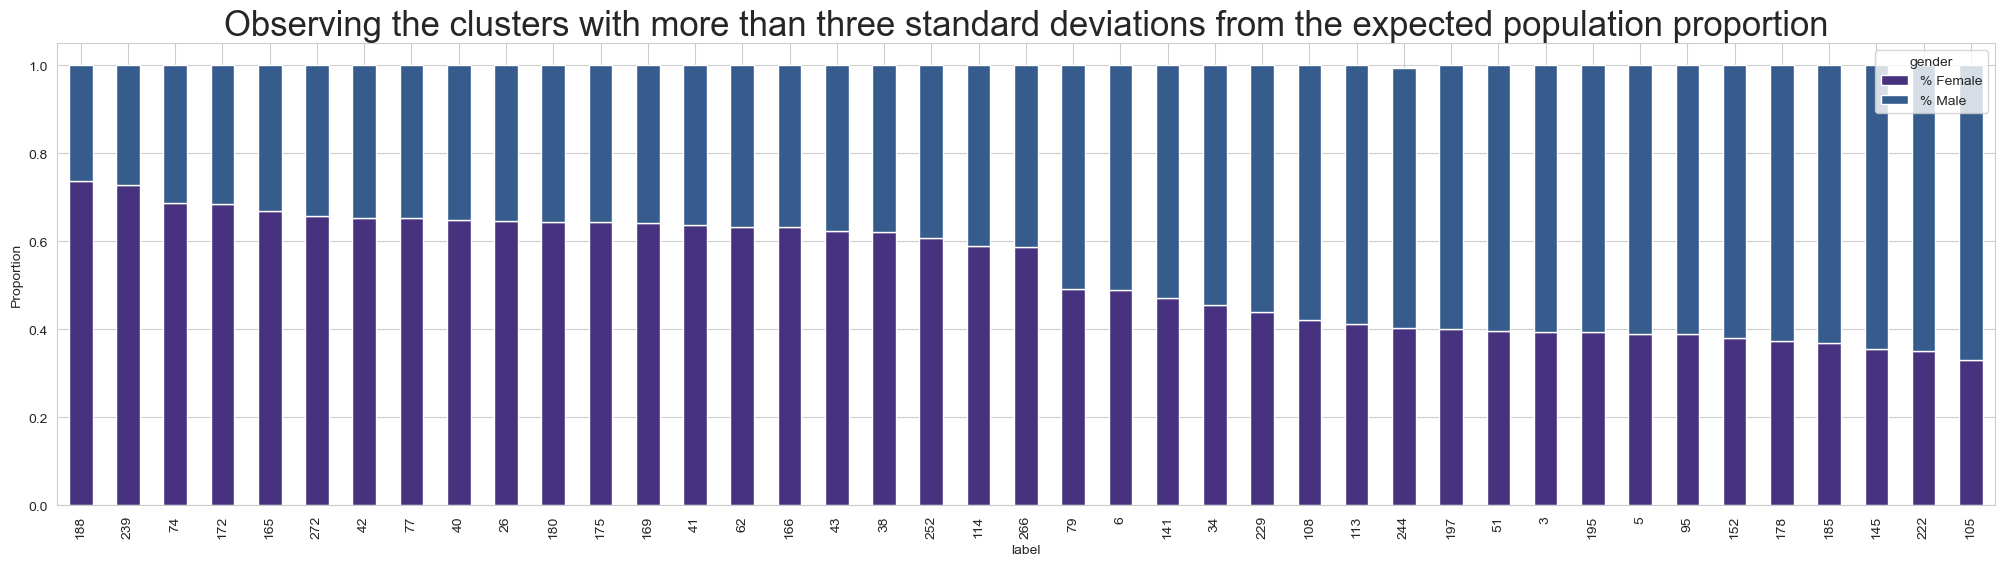

In [316]:
# Plot the stacked bar chart
signif_clusters[['% Female','% Male']].plot(kind = 'bar', stacked = True, figsize = (25, 6))
plt.title('Observing the clusters with more than three standard deviations from the expected population proportion', fontsize = 25)
plt.ylabel('Proportion')

#### Results - Age

In [317]:
# Assessing population statistics for each cluster
age_count = results_df_noiseless.groupby(['label', 'age']).size().reset_index(name='age_count')

# Putting a number to overall representation
age_representation = age_count.groupby('age')['age_count'].sum().reset_index()
age_representation['% representation'] = round(100*(age_representation['age_count'])/age_representation['age_count'].sum(), 3)
age_representation

age  age_count  % representation
0    [0-10)        149             0.177
1   [10-20)        593             0.704
2   [20-30)       1313             1.558
3   [30-40)       3052             3.622
4   [40-50)       7919             9.398
5   [50-60)      14177            16.825
6   [60-70)      18544            22.008
7   [70-80)      21687            25.738
8   [80-90)      14404            17.095
9  [90-100)       2422             2.874

Text(0.5, 1.0, 'All patients')

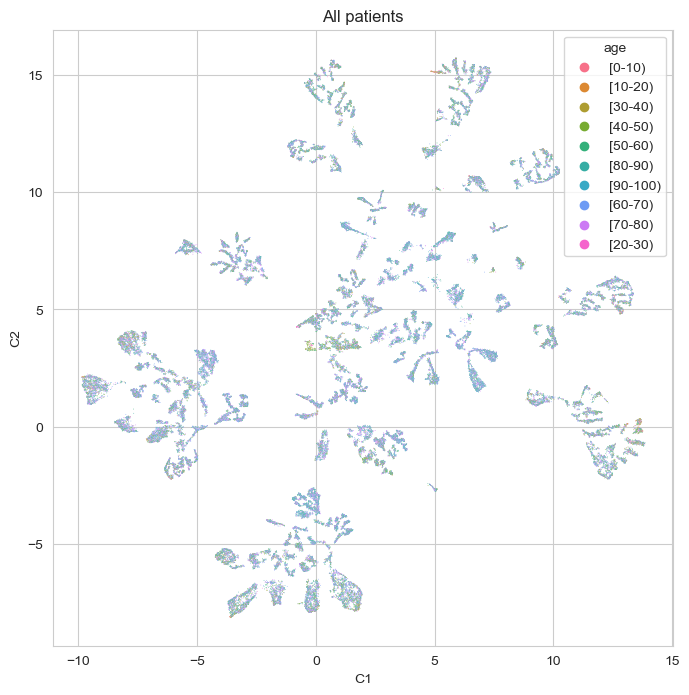

In [318]:
# Scatter plot to identify gender in the umap embedding
plt.figure(figsize = (8, 8))
sns.scatterplot(data = results_df_noiseless, x= 'C1', y ='C2', hue = 'age', s = 0.3, palette = 'husl')
plt.title("All patients")

In [319]:
# Statistical relevance of Age proportion in clusters
results_df_noiseless_copy = results_df_noiseless.copy()
results_df_noiseless_copy['age'] = results_df_noiseless_copy['age'].replace({'[0-10)': 'other',
                                                                             '[10-20)': 'other',
                                                                             '[20-30)': 'other',
                                                                             '[30-40)': 'other',
                                                                             '[40-50)': 'other',
                                                                             '[50-60)': 'other',
                                                                             '[70-80)': 'other',
                                                                             '[80-90)': 'other',
                                                                             '[90-100)': 'other'})


# Contingency table 
contingency_table_age = pd.crosstab(results_df_noiseless_copy['label'], results_df_noiseless_copy['age'])

# Chi-squareed test of independence
chi2_age, p_age, dof_age, expected_age = chi2_contingency(contingency_table_age)

expected_df_age = pd.DataFrame(expected_age, index = contingency_table_age.index, columns = contingency_table_age.columns)
low_counts = (expected_df_age < 5).sum().sum()

if low_counts > 0.2 * expected_df_age.size:
    print("Warning: More than 32% of cells have expected counts below 5 making this statistic less meaningful.")

## Cramer's V (measuring association)
# Summing frequencies
n_age = contingency_table_age.values.sum()
# Getting minimum dimensions
min_dim_age = min(contingency_table_age.shape) - 1
cramers_v_age = np.sqrt(chi2_age / (n_age * min_dim_age))

# Printing results
print(f"Chi2 Statistic: {round(chi2_age, 2)}, P-value: {round(p_age, 2)} (dof = {round(dof_age,2)})")
print(f"Cramér’s V: {round(cramers_v_age, 5)}")

Chi2 Statistic: 1394.87, P-value: 0.0 (dof = 279)
Cramér’s V: 0.12866


In [320]:
# Creating pivot table with age counts alongside a cluster member count
age_count = results_df_noiseless.groupby(['label', 'age']).size().reset_index(name='age_count')
age_count = age_count.pivot_table(index = 'label', 
                                     columns = 'age', 
                                     values = 'age_count', 
                                     aggfunc = 'sum', 
                                     fill_value = 0, 
                                     margins = True)

age_count.drop('All', axis = 0, inplace = True)

# Extending to include proportions of each group
for column in age_count.columns:
    if column == 'All':
        continue
    age_count['% '+ column] = age_count[column]/age_count['All']

# Checking assumptions
age_count['sample_size_valid'] = ((age_count['All'] * age_count['% [60-70)'] >= 10) & 
                                   (age_count['All'] * (1 - age_count['% [60-70)']) >= 10))

# Looking at groups where assumption holds true
age_count = age_count[age_count['sample_size_valid']==True]
age_count

age    [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  [70-80)  \
label                                                                          
0          10       21       16       42       89      170      184      228   
1           0        0        3        6       23       64       50       55   
10          7       15       33       83      166      332      439      376   
100         0        0        1        8        8       19       23       19   
101         0        1        3       10       18       27       26       40   
...       ...      ...      ...      ...      ...      ...      ...      ...   
95          0        1        2        8       39       67       75       64   
96          0        1        5        6       28       38       51       58   
97          0        0       10       16       65       97      116      106   
98          0        0        0        5       20       27       40       27   
99          6        9        6       17       33       46       26       24   

age    [80-90)  [90-100)   All  % [0-10)  % [10-20)  % [20-30)  % [30-40)  \
label                                                                       
0          132        27   919  0.010881   0.022851   0.017410   0.045702   
1           28         2   231  0.000000   0.000000   0.012987   0.025974   
10         127        14  1592  0.004397   0.009422   0.020729   0.052136   
100          6         2    86  0.000000   0.000000   0.011628   0.093023   
101         17         4   146  0.000000   0.006849   0.020548   0.068493   
...        ...       ...   ...       ...        ...        ...        ...   
95          13         1   270  0.000000   0.003704   0.007407   0.029630   
96          42         7   236  0.000000   0.004237   0.021186   0.025424   
97          47         5   462  0.000000   0.000000   0.021645   0.034632   
98          10         0   129  0.000000   0.000000   0.000000   0.038760   
99          14         1   182  0.032967   0.049451   0.032967   0.093407   

age    % [40-50)  % [50-60)  % [60-70)  % [70-80)  % [80-90)  % [90-100)  \
label                                                                      
0       0.096844   0.184984   0.200218   0.248096   0.143634    0.029380   
1       0.099567   0.277056   0.216450   0.238095   0.121212    0.008658   
10      0.104271   0.208543   0.275754   0.236181   0.079774    0.008794   
100     0.093023   0.220930   0.267442   0.220930   0.069767    0.023256   
101     0.123288   0.184932   0.178082   0.273973   0.116438    0.027397   
...          ...        ...        ...        ...        ...         ...   
95      0.144444   0.248148   0.277778   0.237037   0.048148    0.003704   
96      0.118644   0.161017   0.216102   0.245763   0.177966    0.029661   
97      0.140693   0.209957   0.251082   0.229437   0.101732    0.010823   
98      0.155039   0.209302   0.310078   0.209302   0.077519    0.000000   
99      0.181319   0.252747   0.142857   0.131868   0.076923    0.005495   

age    sample_size_valid  
label                     
0                   True  
1                   True  
10                  True  
100                 True  
101                 True  
...                  ...  
95                  True  
96                  True  
97                  True  
98                  True  
99                  True  

[279 rows x 22 columns]

In [321]:
# Preparing containers to hold z-scores and p-values 
z_stats_6070 = []
p_value_6070 = []

# Looping through each cluster
indexation = age_count.index.to_list()
for element in indexation:
    # z_stats_Afr_Ameri.append
    z_stats, p_value  = z_stat(age_count, element, '[60-70)')
    z_stats_6070.append(z_stats)
    p_value_6070.append(p_value)

# Adding these values to the dataframe
age_count['60-69 z-score'] = z_stats_6070
age_count['60-69 p-value'] = p_value_6070

In [322]:
# Observing clusters with p-values of <0.05
significant_6070 = age_count[age_count['60-69 p-value'] <= 0.05]
num_signif_clusters = len(significant_6070)
odd_z_stat = len(significant_6070[(significant_6070['60-69 z-score']>3) | (significant_6070['60-69 z-score']<-3)])
print(f'There are {num_signif_clusters} clusters demonstrating significance (p-value < 0.05). Of these, {odd_z_stat} \
had a z-stat score that indicated Females in the clusters are more than three standard deviations away from the expected \
proportion.')

There are 89 clusters demonstrating significance (p-value < 0.05). Of these, 42 had a z-stat score that indicated Females in the clusters are more than three standard deviations away from the expected proportion.


In [323]:
# Checking cluster sizes
signif_cluster_indices = significant_6070[(significant_6070['60-69 z-score']>3) | \
                                        (significant_6070['60-69 z-score']<-3)].index.to_list()
signif_clusters = age_count.loc[signif_cluster_indices].sort_values('% [60-70)', ascending = True)
print(f'You can see below that the clusters in question include between {round((188/84260)*100, 3)}% and {round(1891/84260*100,3)}% \
of the non-noise instances: \n')  
signif_clusters

You can see below that the clusters in question include between 0.223% and 2.244% of the non-noise instances: 



age    [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  [70-80)  \
label                                                                          
60         44       51       19       21       29       32       11       11   
249         0        0        0        1        1       10       13       62   
42          0        0        0        4       12       38       54      189   
81          0        0        0        0        2       11       14       48   
75          0        0        0        0        1        6       21       76   
188         0        0        0        0        2        4       15       38   
26          0        0        3        0       10       26       61      176   
43          0        0        0        3        5       31       56      168   
89          8       30       30       36       37       40       24       10   
182         0        0        0        1        3       15       28       77   
74          0        0        1        1        2       15       26       63   
88          2       13       12       25       52       51       28       25   
272         0        0        0        0        1       13       28       57   
58          0        0        1        2        3       14       42      117   
77          0        0        2        0        7       19       40      103   
41          0        0        2        3       20       80      135      269   
175         0        0        0        2       19       45      150      336   
2           1        4        6       15       36       66       66      138   
252         0        0        2        4       16       43       88      187   
4           0        0        2        4       14       24       54       91   
38          0        1        1        0        6       22       60      124   
40          0        0        2        7       15       52      137      280   
214         0        3       10       36       71      101       64       76   
266         0        6       50       99      201      229      163      129   
18          1        0        3        8       32       86      159      264   
141         2       15       34       92      258      416      496      412   
79          4        7       17       39      153      244      350      309   
10          7       15       33       83      166      332      439      376   
6           0        0        2       24       84      187      262      286   
220         0        2        6        7       58       93      180      199   
200         0       13       23       39      113      202      302      251   
229         0        1        4       20       32      100      119      116   
35          0        1        0        8       36       61       96       86   
197         0        0        0        5       26       87      118      131   
201         0        0        1        5       18       47       85       71   
105         0        1        0        4       26       44       60       37   
152         0        0        2        2       17       52       56       34   
207         0        0        1        1       11       32       44       28   
193         0        0        0        1       15       31       57       49   
185         0        0        0        1        6       20       38       34   
244         0        0        0        3       12       39       65       48   
222         0        0        1        5       22       71      106       64   

age    [80-90)  [90-100)   All  % [0-10)  % [10-20)  % [20-30)  % [30-40)  \
label                                                                       
60           3         0   221  0.199095   0.230769   0.085973   0.095023   
249         73        34   194  0.000000   0.000000   0.000000   0.005155   
42         314        95   706  0.000000   0.000000   0.000000   0.005666   
81          77        22   174  0.000000   0.000000   0.000000   0.000000   
75          94   

In [324]:
common_index = contingency_table_age.index.intersection(signif_clusters.index).to_list()
binary_age_count = contingency_table_age.loc[common_index]
binary_age_count['% 60-69'] = binary_age_count['[60-70)']/(binary_age_count['[60-70)']+binary_age_count['other'])
binary_age_count['% other'] = binary_age_count['other']/(binary_age_count['[60-70)']+binary_age_count['other'])
binary_age_count 

age    [60-70)  other   % 60-69   % other
label                                    
10         439   1153  0.275754  0.724246
105         60    128  0.319149  0.680851
141        496   1395  0.262295  0.737705
152         56    115  0.327485  0.672515
175        150    905  0.142180  0.857820
18         159    762  0.172638  0.827362
182         28    217  0.114286  0.885714
185         38     70  0.351852  0.648148
188         15    145  0.093750  0.906250
193         57    109  0.343373  0.656627
197        118    274  0.301020  0.698980
2           66    394  0.143478  0.856522
200        302    774  0.280669  0.719331
201         85    196  0.302491  0.697509
207         44     89  0.330827  0.669173
214         64    343  0.157248  0.842752
220        180    465  0.279070  0.720930
222        106    171  0.382671  0.617329
229        119    300  0.284010  0.715990
244         65    114  0.363128  0.636872
249         13    181  0.067010  0.932990
252         88    500  0.149660  0.850340
26          61    567  0.097134  0.902866
266        163    796  0.169969  0.830031
272         28    189  0.129032  0.870968
35          96    235  0.290030  0.709970
38          60    337  0.151134  0.848866
4           54    304  0.150838  0.849162
40         137    748  0.154802  0.845198
41         135    836  0.139032  0.860968
42          54    652  0.076487  0.923513
43          56    457  0.109162  0.890838
58          42    283  0.129231  0.870769
6          262    679  0.278427  0.721573
60          11    210  0.049774  0.950226
74          26    194  0.118182  0.881818
75          21    208  0.091703  0.908297
77          40    268  0.129870  0.870130
79         350    958  0.267584  0.732416
81          14    160  0.080460  0.919540
88          28    195  0.125561  0.874439
89          24    193  0.110599  0.889401

Text(0, 0.5, 'Proportion')

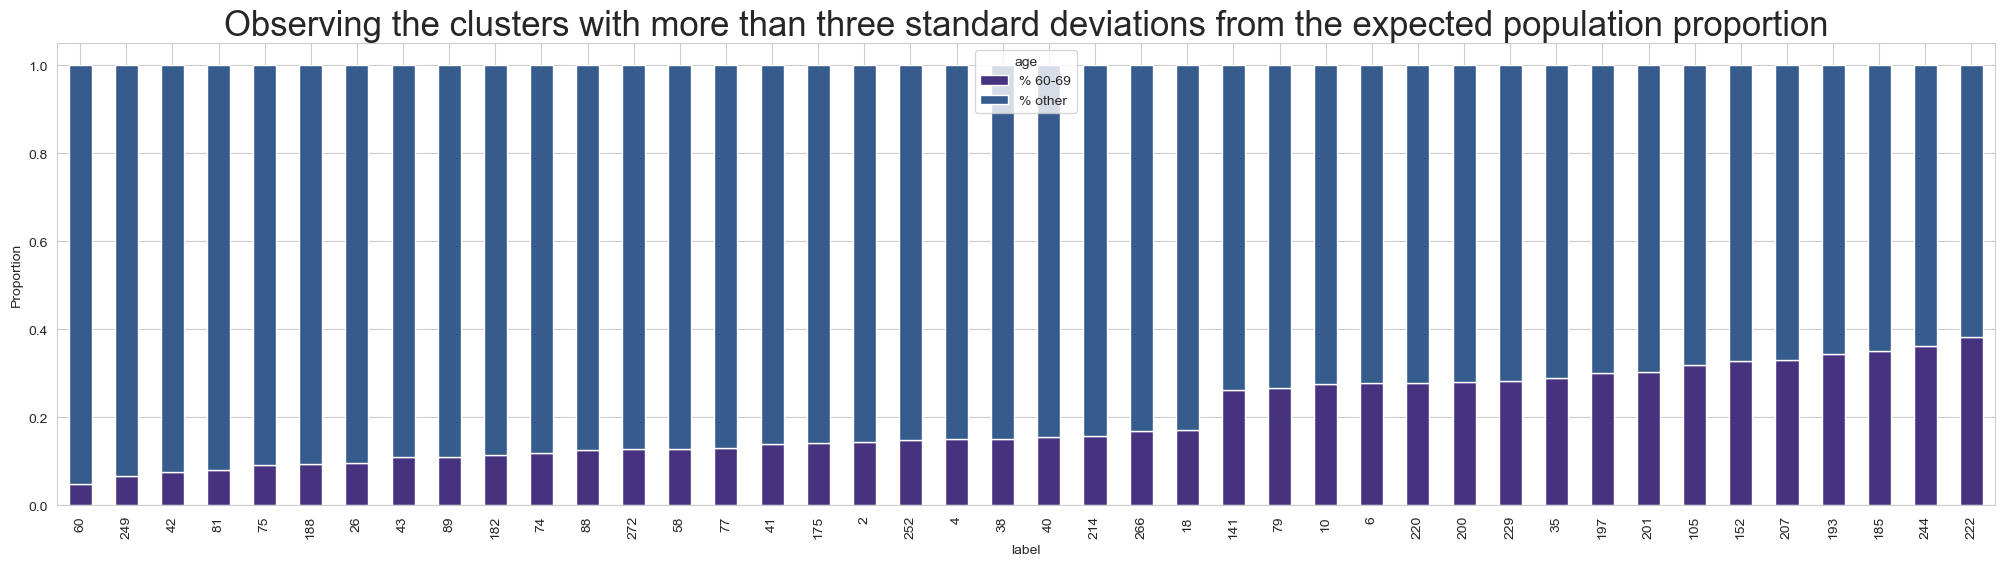

In [325]:
# Making it more obivous by making it a binary again 
common_index = contingency_table_age.index.intersection(signif_clusters.index).to_list()
binary_age_count = contingency_table_age.loc[common_index]
binary_age_count['% 60-69'] = binary_age_count['[60-70)']/(binary_age_count['[60-70)']+binary_age_count['other'])
binary_age_count['% other'] = binary_age_count['other']/(binary_age_count['[60-70)']+binary_age_count['other'])
binary_age_count.sort_values('% 60-69', inplace = True)

# Plot the stacked bar chart
binary_age_count.iloc[:, 2:].plot(kind = 'bar', stacked = True, figsize = (25, 6))
plt.title('Observing the clusters with more than three standard deviations from the expected population proportion', fontsize = 25)
plt.ylabel('Proportion')

No obvious dominance or otherwise observed


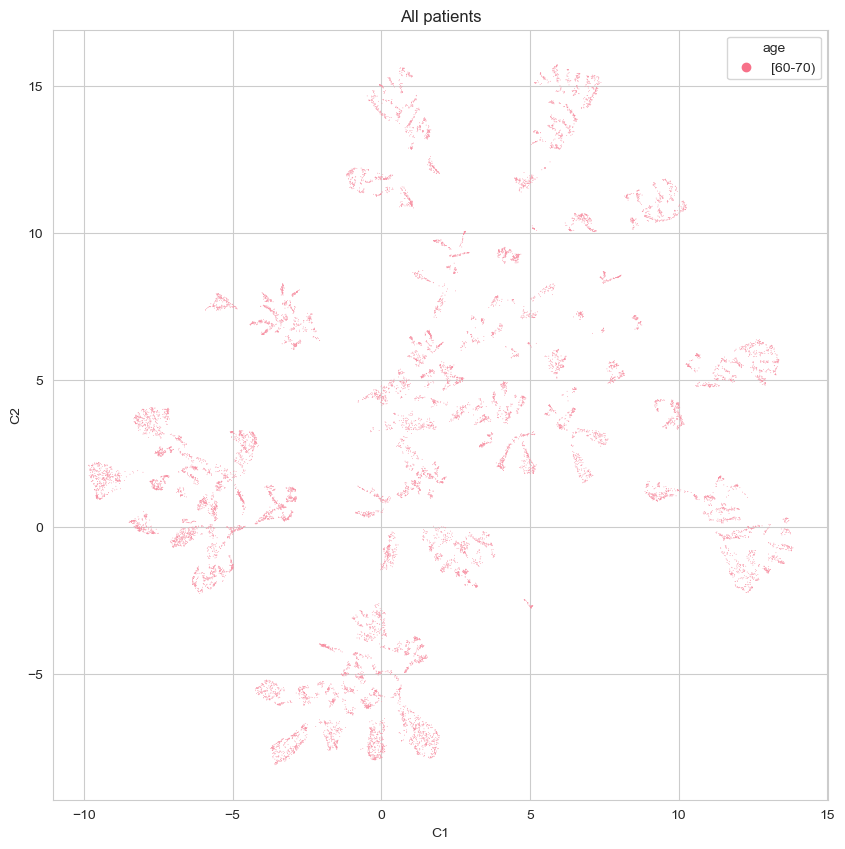

In [326]:
# Observinf the embedding for just those aged 60-69
data = results_df_noiseless[results_df_noiseless['age'] == '[60-70)']

# Scatter plot to identify age 60-69 year olds
plt.figure(figsize = (10, 10))
sns.scatterplot(data = data, x= 'C1', y ='C2', hue = 'age', s = 0.3, palette = 'husl')
plt.title("All patients")
print('No obvious dominance or otherwise observed')

#### Example analysis for specific investigations

In [327]:
## Taking selection
# Race
ethnicity_ = int(input("Please select an ethnicity:" + 
"\n1 = Caucasian\n2 = African American\n3 = Hispanic\n4 = Asian\n5 = Other \n"))

if ethnicity_ == 1:
    ethnicity = 'Caucasian'
elif ethnicity_ == 2:
    ethnicity = 'AfricanAmerican'
elif ethnicity_ == 3:
    ethnicity = 'Hispanic'
elif ethnicity_ == 4:
    ethnicity = 'Asian'
elif ethnicity_ == 5:
    ethnicity = 'other'

# Gender
gender_ = int(input("Please select a gender:" + 
"\n1 = Male\n2 = Female\n"))

if gender_ == 1:
    gender = 'Male'
elif gender_ == 2:
    gender = 'female'

# Age
age_ = int(input("Please select an ethnicity:" +
"\n1 = [0-10)\n2 = [10-20)\n3 = [30-40)\n4 = [40-50)\n5 = [50-60)\n6 = [80-90)\n7 = [90-100)\n8 = [60-70)\n9 = [70-80)\n10 = [20-30)\n"))

if age_ == 1:
     age = '[0-10)'
if age_ == 2:
     age = '[10-20)'
if age_ == 3:
     age = '[30-40)'
if age_ == 4:
     age = '[40-50)'
if age_ == 5:
     age = '[50-60)'
if age_ == 6:
     age = '[80-90)'
if age_ == 7:
     age = '[90-100)'
if age_ == 8:
     age = '[60-70)'
if age_ == 9:
     age = '[70-80)'
if age_ == 10:
     age = '[20-30)'

print(f"You have selected: {ethnicity, gender, age}") 

Please select an ethnicity:
1 = Caucasian
2 = African American
3 = Hispanic
4 = Asian
5 = Other 
 1
Please select a gender:
1 = Male
2 = Female
 1
Please select an ethnicity:
1 = [0-10)
2 = [10-20)
3 = [30-40)
4 = [40-50)
5 = [50-60)
6 = [80-90)
7 = [90-100)
8 = [60-70)
9 = [70-80)
10 = [20-30)
 5


You have selected: ('Caucasian', 'Male', '[50-60)')


5269
No obvious dominance or otherwise observed


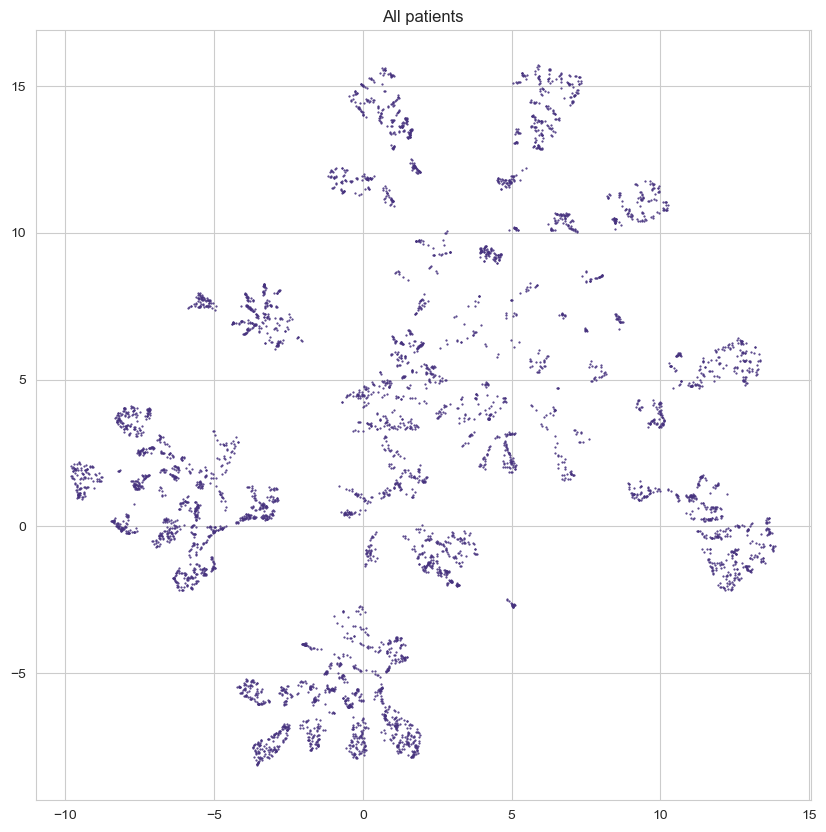

In [328]:
# Taking this subset of the data
selected = results_df_noiseless[(results_df_noiseless['race']== ethnicity) & \
                                (results_df_noiseless['gender']== gender) & \
                                (results_df_noiseless['age']== age)]
print(len(selected))

# Locating the selected subset
plt.figure(figsize = (10, 10))
plt.scatter(selected['C1'], selected['C2'], s = 0.3)
plt.title("All patients")
print('No obvious dominance or otherwise observed')

In [329]:
# Create a cross-tabulation (contingency table) with clusters and the group (Black men aged 40-50)
# We create a binary column for whether an individual is in the target group (Black male aged 40-50)
all_data = results_df_noiseless.copy()
all_data['selected'] = all_data['label'].apply(lambda x: 1 if x in selected['label'].values else 0)

# Create the contingency table: rows = clusters, columns = "Black Male 40-50" vs "Not"
contingency_table_selected = pd.crosstab(all_data['label'], all_data['selected'], margins = False)

# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_selected)

# Print the results
print(f"Chi-square stat: {chi2_stat}, p-value: {p_val}, Degrees of freedom: {dof}")

Chi-square stat: 84260.00000000001, p-value: 0.0, Degrees of freedom: 279


In [330]:
all_data

race  gender      age         C1        C2 label  selected
0            Caucasian  Female   [0-10)  -5.533030  7.959600     0         1
1            Caucasian  Female  [10-20)  12.470757  6.300847   121         1
3            Caucasian    Male  [30-40)  12.283931 -0.073393   158         1
4            Caucasian    Male  [40-50)  13.795531 -0.796851    70         1
5            Caucasian    Male  [50-60)  -1.903242 -6.626352    47         1
...                ...     ...      ...        ...       ...   ...       ...
99487  AfricanAmerican  Female  [60-70)   0.873537  2.109731   271         1
99488  AfricanAmerican    Male  [70-80)   7.624258  3.006589    40         1
99489  AfricanAmerican  Female  [80-90)   6.590817  7.335567     4         1
99490        Caucasian    Male  [70-80)  11.307617  1.705047    87         1
99491        Caucasian  Female  [80-90)  -0.134411 -3.481612   175         1

[84260 rows x 7 columns]

In [331]:
# Obtianing count and proportions of selected group 
selected_count = all_data.groupby(['label', 'race', 'gender', 'age']).size().reset_index(name = 'selected_count')
selected_count['race_gender_age'] = selected_count.apply(
    lambda row: 'selected' if row['race'] + row['gender'] + row['age'] == ethnicity + gender + age else 'not selected',
    axis=1)

selected_count = selected_count.pivot_table(index = 'label', 
                                            columns = 'race_gender_age', 
                                            values = 'selected_count', 
                                            aggfunc = 'sum', 
                                            fill_value = 0, 
                                            margins = True)
selected_count.drop('All', axis = 0, inplace = True)

# Extending to include proportions of each group
for column in selected_count.columns:
    if column == 'All':
        continue
    selected_count['% '+ str(column)] = selected_count[column]/selected_count['All']


# Checkin assumpttions
selected_count['sample_size_valid'] = ((selected_count['All'] * selected_count['% selected'] >= 10) & 
                                        (selected_count['All'] * (1 - selected_count['% selected']) >= 10))

# Taking only those that meet the assumption
selected_count = selected_count[selected_count["sample_size_valid"] == True]

selected_count

race_gender_age  not selected  selected   All  % not selected  % selected  \
label                                                                       
0                         851        68   919        0.926007    0.073993   
1                         205        26   231        0.887446    0.112554   
10                       1480       112  1592        0.929648    0.070352   
101                       136        10   146        0.931507    0.068493   
102                       410        28   438        0.936073    0.063927   
...                       ...       ...   ...             ...         ...   
94                        498        30   528        0.943182    0.056818   
95                        237        33   270        0.877778    0.122222   
96                        219        17   236        0.927966    0.072034   
97                        428        34   462        0.926407    0.073593   
99                        171        11   182        0.939560    0.060440   

race_gender_age  sample_size_valid  
label                               
0                             True  
1                             True  
10                            True  
101                           True  
102                           True  
...                            ...  
94                            True  
95                            True  
96                            True  
97                            True  
99                            True  

[176 rows x 6 columns]

In [332]:
# Preparing containers to hold z-scores and p-values 
z_stats_selected = []
p_value_selected = []

# Looping through each cluster
indexation = selected_count.index.to_list()
for element in indexation:
    z_stats, p_value  = z_stat(selected_count, element, 'selected')
    z_stats_selected.append(z_stats)
    p_value_selected.append(p_value)

# Adding these values to the dataframe
selected_count['selected z-score'] = z_stats_selected
selected_count['selected p-value'] = p_value_selected
selected_count.sort_values('selected z-score')

race_gender_age  not selected  selected   All  % not selected  % selected  \
label                                                                       
180                      1636        36  1672        0.978469    0.021531   
175                      1038        17  1055        0.983886    0.016114   
40                        874        11   885        0.987571    0.012429   
42                        692        14   706        0.980170    0.019830   
18                        897        24   921        0.973941    0.026059   
...                       ...       ...   ...             ...         ...   
105                       161        27   188        0.856383    0.143617   
197                       342        50   392        0.872449    0.127551   
141                      1709       182  1891        0.903755    0.096245   
152                       141        30   171        0.824561    0.175439   
222                       233        44   277        0.841155    0.158845   

race_gender_age  sample_size_valid  selected z-score  selected p-value  
label                                                                   
180                           True         -7.685310      1.532108e-14  
175                           True         -6.797874      1.061751e-11  
40                            True         -6.657870      2.778244e-11  
42                            True         -5.172002      2.315989e-07  
18                            True         -5.162694      2.434209e-07  
...                            ...               ...               ...  
105                           True          4.016634      5.903542e-05  
197                           True          4.547026      5.440916e-06  
141                           True          4.624580      3.753573e-06  
152                           True          5.469819      4.504951e-08  
222                           True          5.873840      4.258152e-09  

[176 rows x 8 columns]

Text(0.5, 1.0, 'Observing the clusters with more than three standard deviations from the expected population proportion')

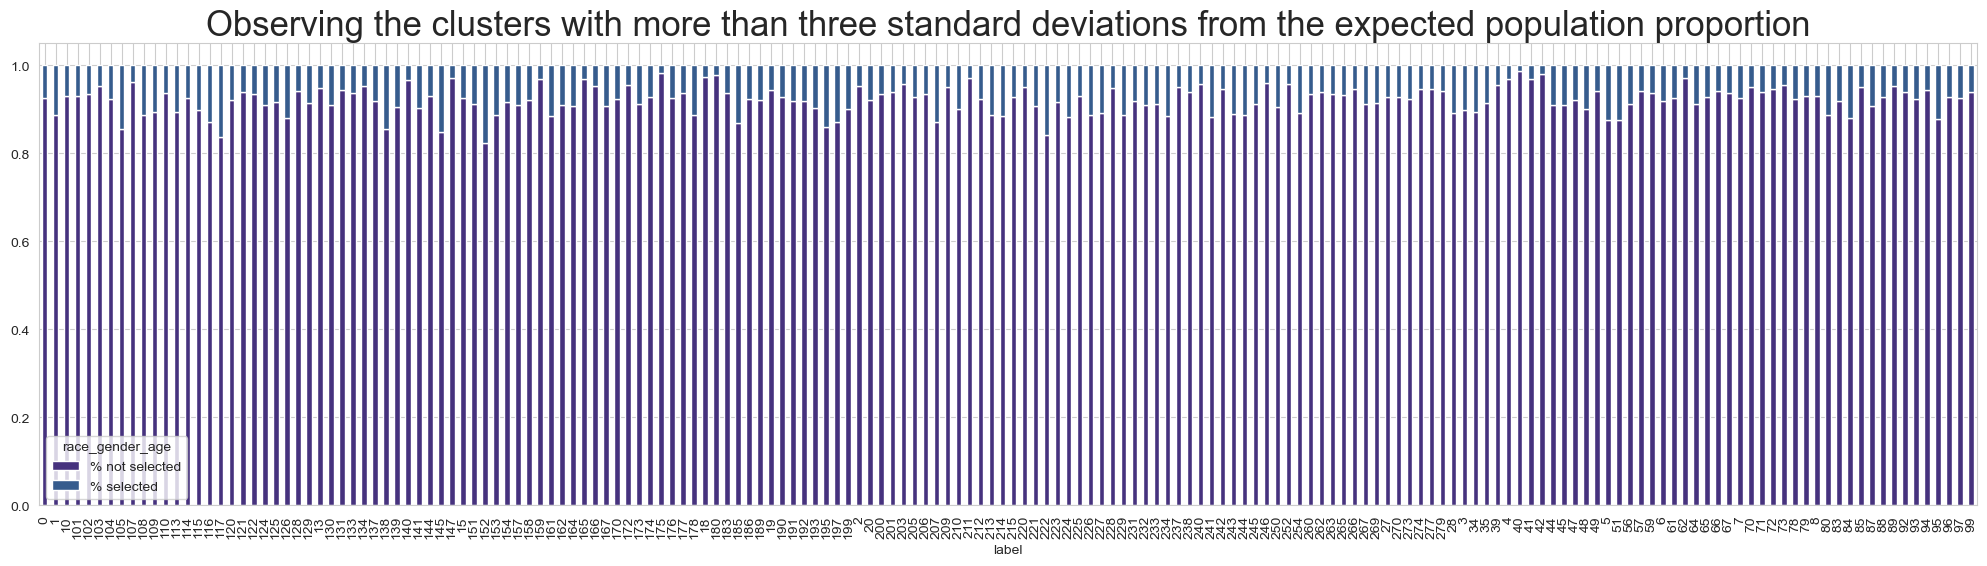

In [333]:
# Plot the stacked bar chart
selected_count.iloc[:, 3:5].plot(kind = 'bar', stacked = True, figsize = (25, 6))
plt.title('Observing the clusters with more than three standard deviations from the expected population proportion', fontsize = 25)

### Final thoughts
There may be a problem in the data.
The medical break-throughs over the decade have not been accounted for. This implies that at some stage in the last decade, its highly likley that the high socio-economic group or other groups least likely to recieve bias may all be represented in each cluster. As the treatment falls out of favour it may then start to increase in representation from minority groups or underprivledged groups. It is unclear how this would influence the patterns in the features used in this particular dataset. Regardless, the process seems to be effective though it should be verified on other datasets in other domains with domain specialists.